Modules.

In [1]:
# custom module
import topodisc

In [1]:
import numpy as np
from numpy import radians as rad
from numpy import degrees as deg
from numpy import sin, cos, tan, arcsin, arccos, arctan, arctan2, mean

import pandas as pd
from dataclasses import dataclass
import itertools

import warnings
from scipy.optimize import curve_fit, OptimizeWarning
from sklearn.metrics import mean_squared_error

warnings.simplefilter("error", OptimizeWarning)

from typing import Callable, Tuple
from collections.abc import Iterable

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

Numerical constants.

In [2]:
SHEAR_MODULUS = 2.4e10  # Pa
ROCK_DENSITY = 2700  # kg / m^3
MAGMA_DENSITY = 2700  # kg / m^3
MARS_GRAVITY = 3.72  # m / s^2
MARS_EQ_RADIUS = 3_396_200  # m

AZ1_UNCERTAINTY = 7  # degrees

# for plotting numerical
PLOT_WIDTH = 200_000

# scale length dimensions to prevent overflow
LENGTH_SCALE_MULT = 1_000_000

# for cutoff envelope and first guess in non-linear regression
MAX_EPV = 7e22  # J
TEST_D = 20_000  # m
MAX_ITERATIONS = 80

# parameter conversion factor
EPV_OVER_K = 16 * np.pi * SHEAR_MODULUS / 9

## Functions

In [3]:
def save_pdf(name: str = 'plot'):
    plt.tight_layout()  # prevent clipping edge labels
    plt.savefig(f'figures/{name}.pdf')


def mogi_tilt(dist, epv, d):
    k = epv / EPV_OVER_K

    # scale to prevent overflow
    r1_scale = dist / LENGTH_SCALE_MULT
    k_scale = k / (LENGTH_SCALE_MULT ** 3)
    d_scale = d / LENGTH_SCALE_MULT

    num = 3 * k_scale * d_scale * r1_scale
    denom = (d_scale**2 + r1_scale**2)**2.5 + \
        k_scale * (d_scale**2 - 2*r1_scale**2)
    return np.degrees(np.arctan2(num, denom))


def epv_numerical_model(depth, radius, aspect, pmult):

    volume = (4/3) * np.pi * radius**3 * aspect
    pressure = ROCK_DENSITY * MARS_GRAVITY * depth * pmult
    return volume * pressure


def great_circle_distance(lat1_deg, lon1_deg, lat2_deg, lon2_deg, radius=MARS_EQ_RADIUS):
    '''distance between pts 1 and 2'''
    lat1 = rad(lat1_deg)
    lon1 = rad(lon1_deg)
    lat2 = rad(lat2_deg)
    lon2 = rad(lon2_deg)

    angular_distance = arccos(
        cos(lat1) * cos(lat2)
        * cos(lon2 - lon1)
        + sin(lat1) * sin(lat2)
    )

    return angular_distance * radius


def great_circle_bearing(lat1_deg, lon1_deg, lat2_deg, lon2_deg):
    '''azimuth from pt 1 AWAY from pt 2'''

    lat1 = rad(lat1_deg)
    lon1 = rad(lon1_deg)
    lat2 = rad(lat2_deg)
    lon2 = rad(lon2_deg)

    y = sin(lon2 - lon1) * cos(lat2)
    x = cos(lat1) * sin(lat2) \
        - sin(lat1) * cos(lat2) * cos(lon2 - lon1)

    return (180 + deg(arctan2(y, x))) % 360


def signed_angular_difference(ang2_deg, ang1_deg):
    '''angular difference expressed in range -180 to 180'''

    return ((ang2_deg - ang1_deg + 180) % 360) - 180


def angular_difference(ang2_deg, ang1_deg):
    return np.abs(signed_angular_difference(ang2_deg, ang1_deg))


def paleo_slope(beta1_deg, beta2_deg, sl2_deg):
    beta1 = rad(beta1_deg)
    beta2 = rad(beta2_deg)
    sl2 = rad(sl2_deg)
    argument = sin(beta2) * sin(sl2) / sin(beta1)
    if argument < 0 or argument > 1:  # not possible
        return np.nan
    else:
        return deg(arcsin(argument))


def great_circle_projection(beta_deg, slope_deg):
    '''project point onto great circle'''

    beta = rad(beta_deg)
    slope = rad(slope_deg)
    proj = arctan(tan(slope) * cos(beta))
    return deg(proj)


def minimum_tilt(
    beta1_deg,
    beta2_deg,
    slope_deg,
    paleo_azimuth_uncertainty=AZ1_UNCERTAINTY
):

    # already within uncertainty -> tilt = 0
    if np.abs(signed_angular_difference(
            beta1_deg, beta2_deg
    )) < paleo_azimuth_uncertainty:
        return 0

    # beta1 uncertainty boundaries
    beta1_possible = np.array([
        beta1_deg + paleo_azimuth_uncertainty,
        beta1_deg - paleo_azimuth_uncertainty
    ])

    nearest_beta1 = min(
        beta1_possible,
        key=lambda beta1_deg: angular_difference(beta1_deg, beta2_deg)
    )

    best_paleo_slope = paleo_slope(
        beta1_deg=nearest_beta1,
        beta2_deg=beta2_deg,
        sl2_deg=slope_deg
    )

    # no paleo_slope -> no tilt
    if np.isnan(best_paleo_slope):
        return np.nan

    # evaluate tilt
    tilt = great_circle_projection(beta2_deg, slope_deg) \
        - great_circle_projection(nearest_beta1, best_paleo_slope)

    return tilt


def is_tiltable(tilt, dist_m):
    '''check whether a given tilt-distance pair is within the tilt envelope'''

    if np.isnan(tilt):
        return False

    max_tilt = mogi_tilt(dist=dist_m, epv=MAX_EPV, d=TEST_D)
    min_tilt = mogi_tilt(dist=dist_m, epv=-MAX_EPV, d=TEST_D)

    if tilt > max_tilt:
        return False
    if tilt < min_tilt:
        return False

    return True

Ensuring correct tilt calculations for a test point.

/var/folders/jx/0qffyvd568l0vd7h4x8pk1640000gn/T/ipykernel_9446/3919329485.py:72: RuntimeWarning: divide by zero encountered in double_scalars
  argument = sin(beta2) * sin(sl2) / sin(beta1)


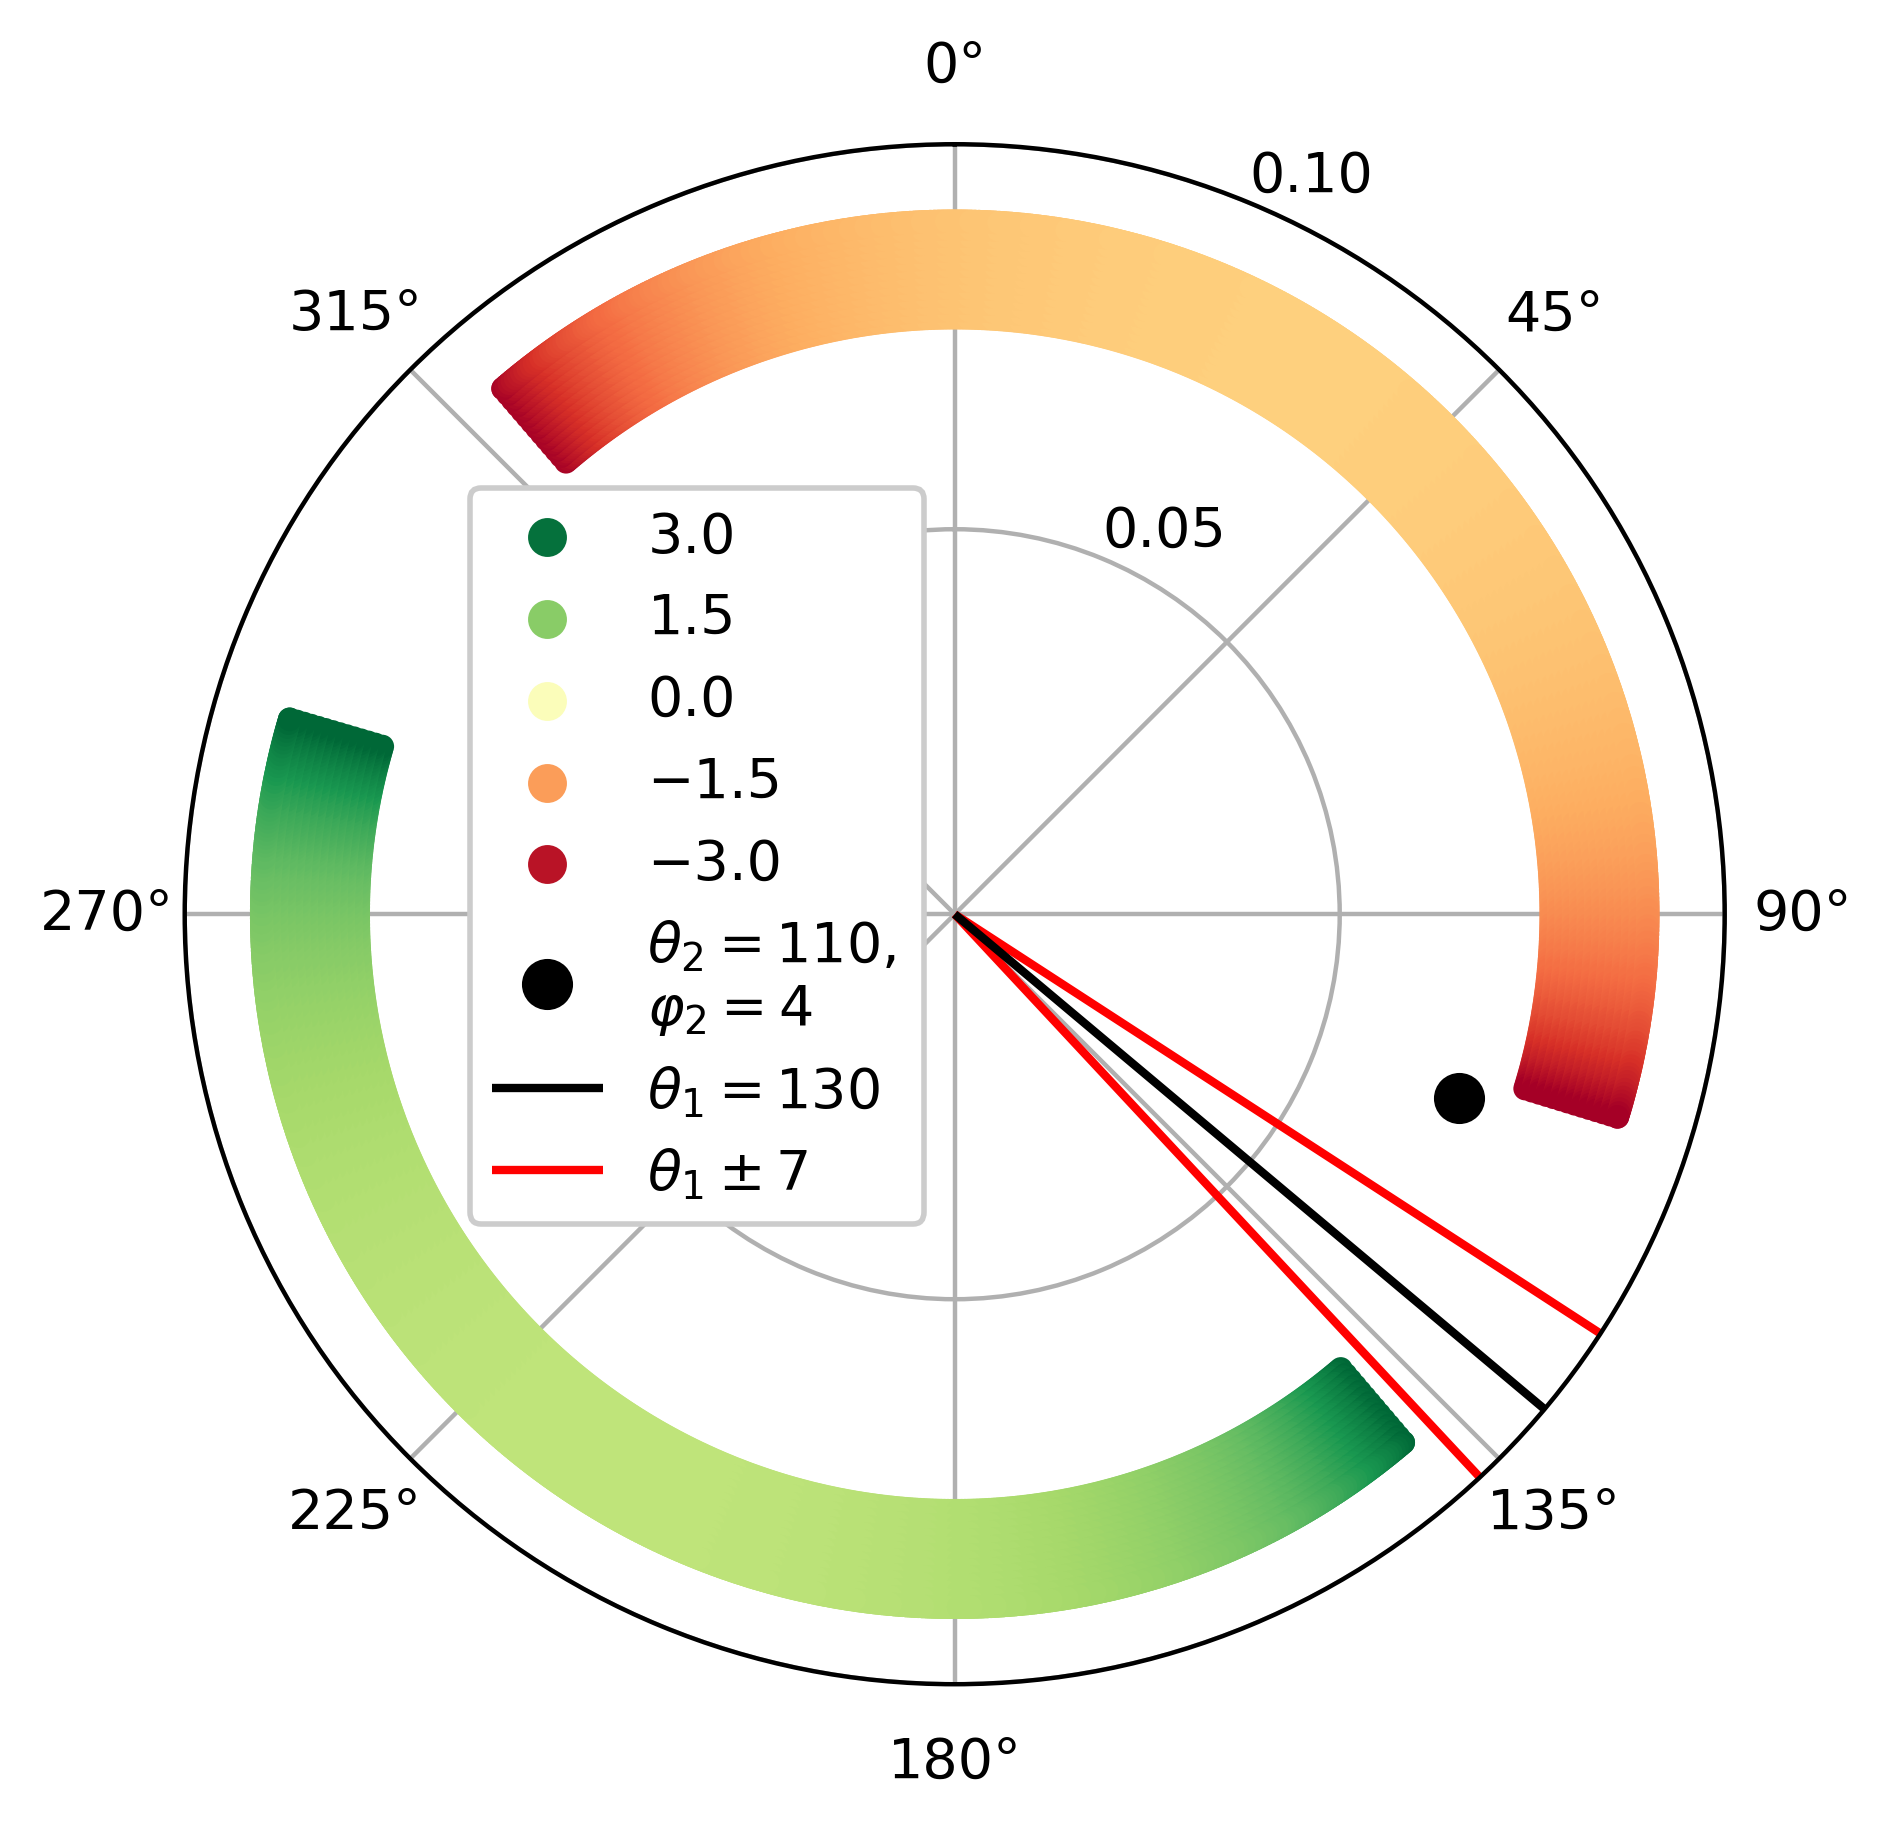

In [5]:
def tilt_check(az1: float, az2: float, sl2: float, resolution: float = 3):  # type: ignore

    test_bearing = np.arange(360 * resolution) / resolution

    plot_radius = 0.1
    test_rim = 0.9 * plot_radius * np.ones(len(test_bearing))

    test_az1 = az1
    test_az2 = az2
    test_sl2 = sl2

    test_tilt = []

    for bearing in test_bearing:
        this_beta1 = signed_angular_difference(ang2_deg=test_az1, ang1_deg=bearing)
        this_beta2 = signed_angular_difference(ang2_deg=test_az2, ang1_deg=bearing)
        this_tilt = minimum_tilt(beta1_deg=this_beta1,
                         beta2_deg=this_beta2, slope_deg=test_sl2,)
        if is_tiltable(tilt=this_tilt, dist_m=10_000):
            test_tilt.append(this_tilt)
        else:
            test_tilt.append(np.nan)

    nptest_tilt = np.array(test_tilt)

    f, ax = plt.subplots(
        subplot_kw={'projection': 'polar'}, figsize=(5, 5), dpi=400)

    ax.set_theta_direction(-1)  # type: ignore
    ax.set_theta_offset(np.pi/2.0)  # type: ignore

    # radial limit
    plt.ylim(0, plot_radius)

    # plot az1 uncertainty range
    ax.vlines(x=np.radians((test_az1+AZ1_UNCERTAINTY, test_az1-AZ1_UNCERTAINTY)),
              ymin=0, ymax=plot_radius, label=f"$\\theta_1 \pm$" + f"{AZ1_UNCERTAINTY}", color='red')
    
    # plot measured az1
    ax.vlines(x=np.radians(test_az1), ymin=0, ymax=plot_radius,
              colors=['black'], label=f"$\\theta_1=$" + f"{az1}")

    # plot modern topographic attitude
    sns.scatterplot(x=[np.radians(test_az2)], y=[np.sin(np.radians(test_sl2))],
                    label='$\\theta_2=$' + f'{az2}, \n' + '$\\varphi_2=$' + f'{sl2}', color='black', s=100)

    # nice radial ticks
    ax.set_yticks(np.linspace(0, plot_radius, 3)[1:])

    # plot calculated tilt by color around the rim. bearing + 180 to show direction TOWARD the center
    for i in np.linspace(.85,1,15):
        if i == .85:
            sns.scatterplot(
                x = np.radians(test_bearing + 180),
                y = test_rim,
                hue = nptest_tilt,
                linewidth = 0,
                palette='RdYlGn',
                size=1,
                # legend=False
            )
        else:
            sns.scatterplot(
                x=np.radians(test_bearing + 180),
                y= i * test_rim,
                hue=nptest_tilt,
                linewidth=0,
                palette='RdYlGn',
                size=1,
                legend=False
            )

    # plt.title("Tilt required to explain a discordant sample \n by direction toward the center. All angles in degrees.")
    # plt.legend(, loc='upper left')
    handles, labels = ax.get_legend_handles_labels()

    # this is a hack to remove the "1" that appears randomly in the legend in the for loop implementation of thick rim
    handles = handles[:-1]
    labels = labels[:-1]

    ax.legend(
        handles[::-1],
        labels[::-1],
        loc='upper left',
        framealpha=1,
        bbox_to_anchor=(0.167, 0.795)
    )

    ax.set_axisbelow(True)


tilt_check(az1=130, az2=110, sl2=4, ) # name='methods/test-tilt1', bbox_to_anchor=(0.167, 0.795) in ax.legend


# tilt_check(az1=130, az2=230, sl2=2,) # name='methods/test-tilt2', bbox_to_anchor=(0.163, 1.02) in ax.legend

Envelope plot.

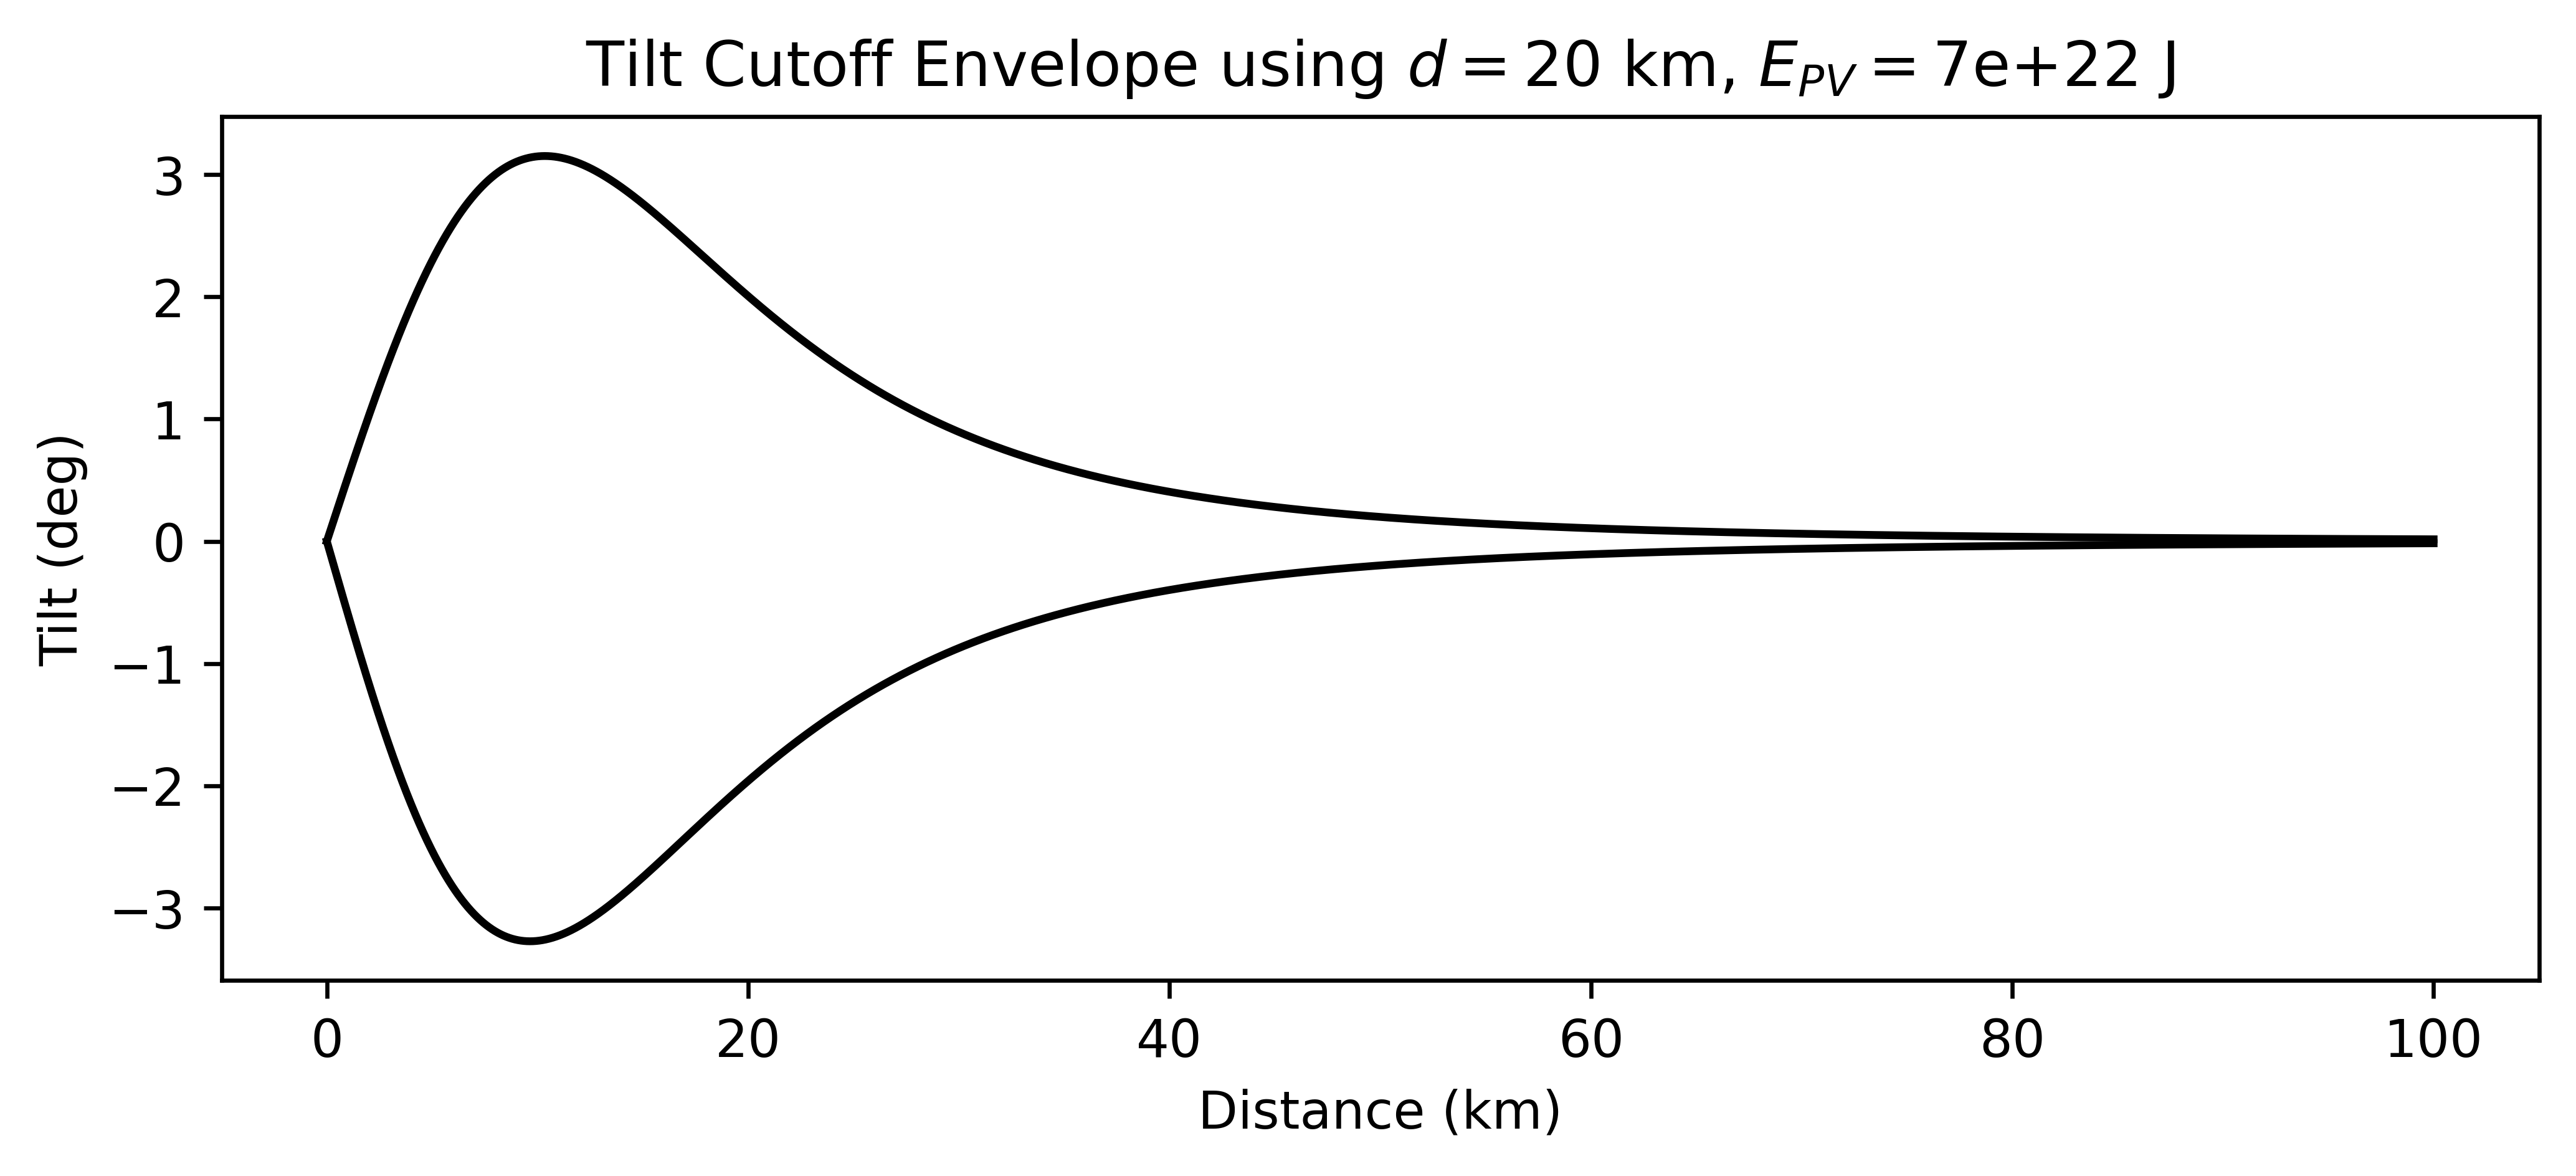

In [9]:
fig = plt.figure(figsize = (8, 3), dpi=600)

plt.ylabel('Tilt (deg)')
plt.xlabel('Distance (km)')


plt.title(f'Tilt Cutoff Envelope using $d = ${int(TEST_D/1000)} km, ' + "$E_{PV} = $" + f'{MAX_EPV} J')


def plot_envelope(min: bool = True, max: bool = True, max_dist_km: float = 100_000):
    dist_m = np.arange(max_dist_km)
    max_tilt = mogi_tilt(dist_m, MAX_EPV, TEST_D)
    min_tilt = mogi_tilt(dist_m, -MAX_EPV, TEST_D)
    dist_km = dist_m / 1000
    if max:
        sns.lineplot(x=dist_km,y=max_tilt, c='black')
    if min:
        sns.lineplot(x=dist_km,y=min_tilt, c='black')

plot_envelope()

# save_pdf(name='methods/envelope')

Illustrating an example of tiltable fraction concept.

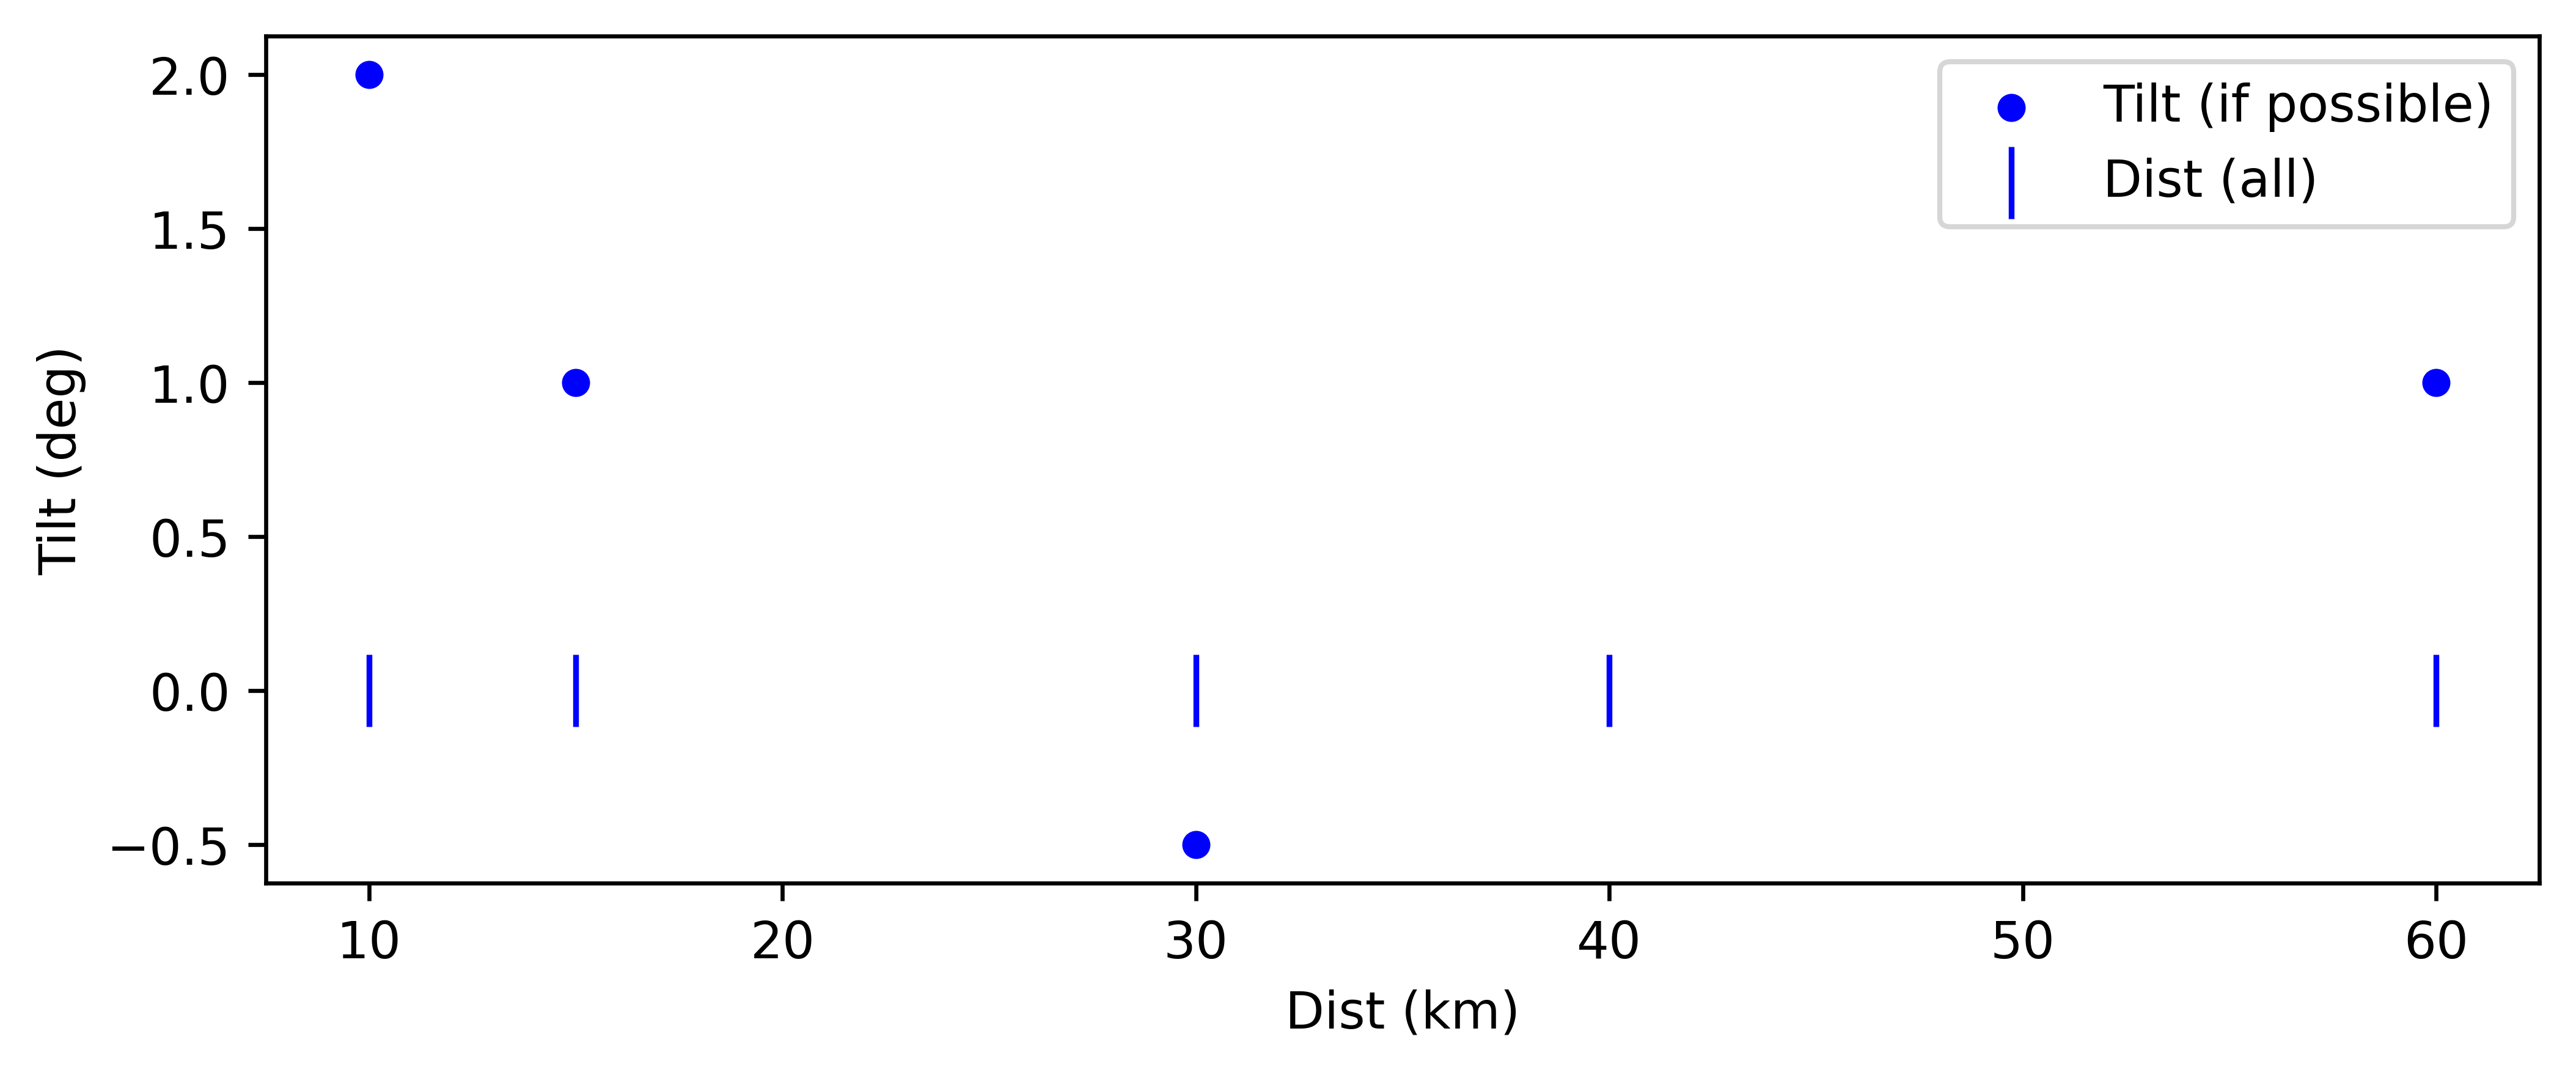

In [57]:
frac_tiltable_example_dataset = pd.DataFrame({
    'dist_km':[10, 15, 30, 40, 60],
    'tilt':[2, 1, -0.5, np.nan, 1]
})

def plot_tilt_distance_dataset(df: pd.DataFrame, has_legend: bool = True, color = None):

    plt.xlabel('Dist (km)')
    plt.ylabel('Tilt (deg)')

    if has_legend:
        tilt_label = 'Tilt (if possible)'
        dist_label = 'Dist (all)'
    else:
        tilt_label = None
        dist_label = None

    sns.scatterplot(
        data=df,
        x='dist_km',
        y='tilt',
        color=color,
        label=tilt_label
    )

    sns.scatterplot(
        x=df['dist_km'],
        y=np.zeros(len(df)),
        marker='|',
        s=200,
        color=color,
        label=dist_label
    )

plt.figure(figsize = (8, 3), dpi=600)

plot_tilt_distance_dataset(frac_tiltable_example_dataset, color='blue')
# plot_tilt_distance_dataset(frac_tiltable_example_dataset, color='orange')

# save_pdf(name='methods/frac-tiltable')

## Map Data

Read samples.csv and centers.csv and extract IDs for each.

In [3]:
map_path = "../GEOL192-GIS/data/"

centers = pd.read_csv(f'{map_path}centers.csv').set_index('cID')
samples = pd.read_csv(f'{map_path}samples.csv').set_index('sID')

cIDs = centers.index.tolist()
sIDs = samples.index.tolist()

feature_sIDs = {
    'flow': samples.index[samples['FEATURE'] == 'flow'].tolist(),
    'channel': samples.index[samples['FEATURE'] == 'channel'].tolist(),
}

Define an object to organize, calculate, and plot map data for a single center point.

In [34]:
@dataclass
class Center:
    cID: int

    def __post_init__(self) -> None:
        self.data = samples.copy()

        # this of course only works for unique self.cIDs
        self.lat = centers.loc[self.cID, 'LAT']
        self.lon = centers.loc[self.cID, 'LON']
        self.calculate()

    def get_data_subset(self, sIDs: list) -> pd.DataFrame:
        return self.data.loc[sIDs]

    def calculate(self):

        self.data['dist'] = self.data.apply(
            lambda row: great_circle_distance(
                lat1_deg=row['LAT'], lon1_deg=row['LON'],
                lat2_deg=self.lat, lon2_deg=self.lon
            ),
            axis=1
        )

        self.data['dist_km'] = self.data.apply(
            lambda row: row['dist'] / 1000,
            axis=1
        )

        self.data['bearing'] = self.data.apply(
            lambda row: great_circle_bearing(
                lat1_deg=row['LAT'], lon1_deg=row['LON'],
                lat2_deg=self.lat, lon2_deg=self.lon
            ),
            axis=1
        )

        self.data['beta1'] = self.data.apply(
            lambda row: signed_angular_difference(
                ang2_deg=row['AZ1'], ang1_deg=row['bearing']
            ),
            axis=1
        )

        self.data['beta2'] = self.data.apply(
            lambda row: signed_angular_difference(
                ang2_deg=row['AZ2'], ang1_deg=row['bearing']
            ),
            axis=1
        )

        self.data['tilt'] = self.data.apply(
            lambda row: minimum_tilt(
                beta1_deg=row['beta1'],
                beta2_deg=row['beta2'],
                slope_deg=row['SL2'],
            ),
            axis=1
        )

        self.data['is_tiltable'] = self.data.apply(
            lambda row: is_tiltable(
                tilt=row['tilt'],
                dist_m=row['dist']
            ),
            axis=1
        )

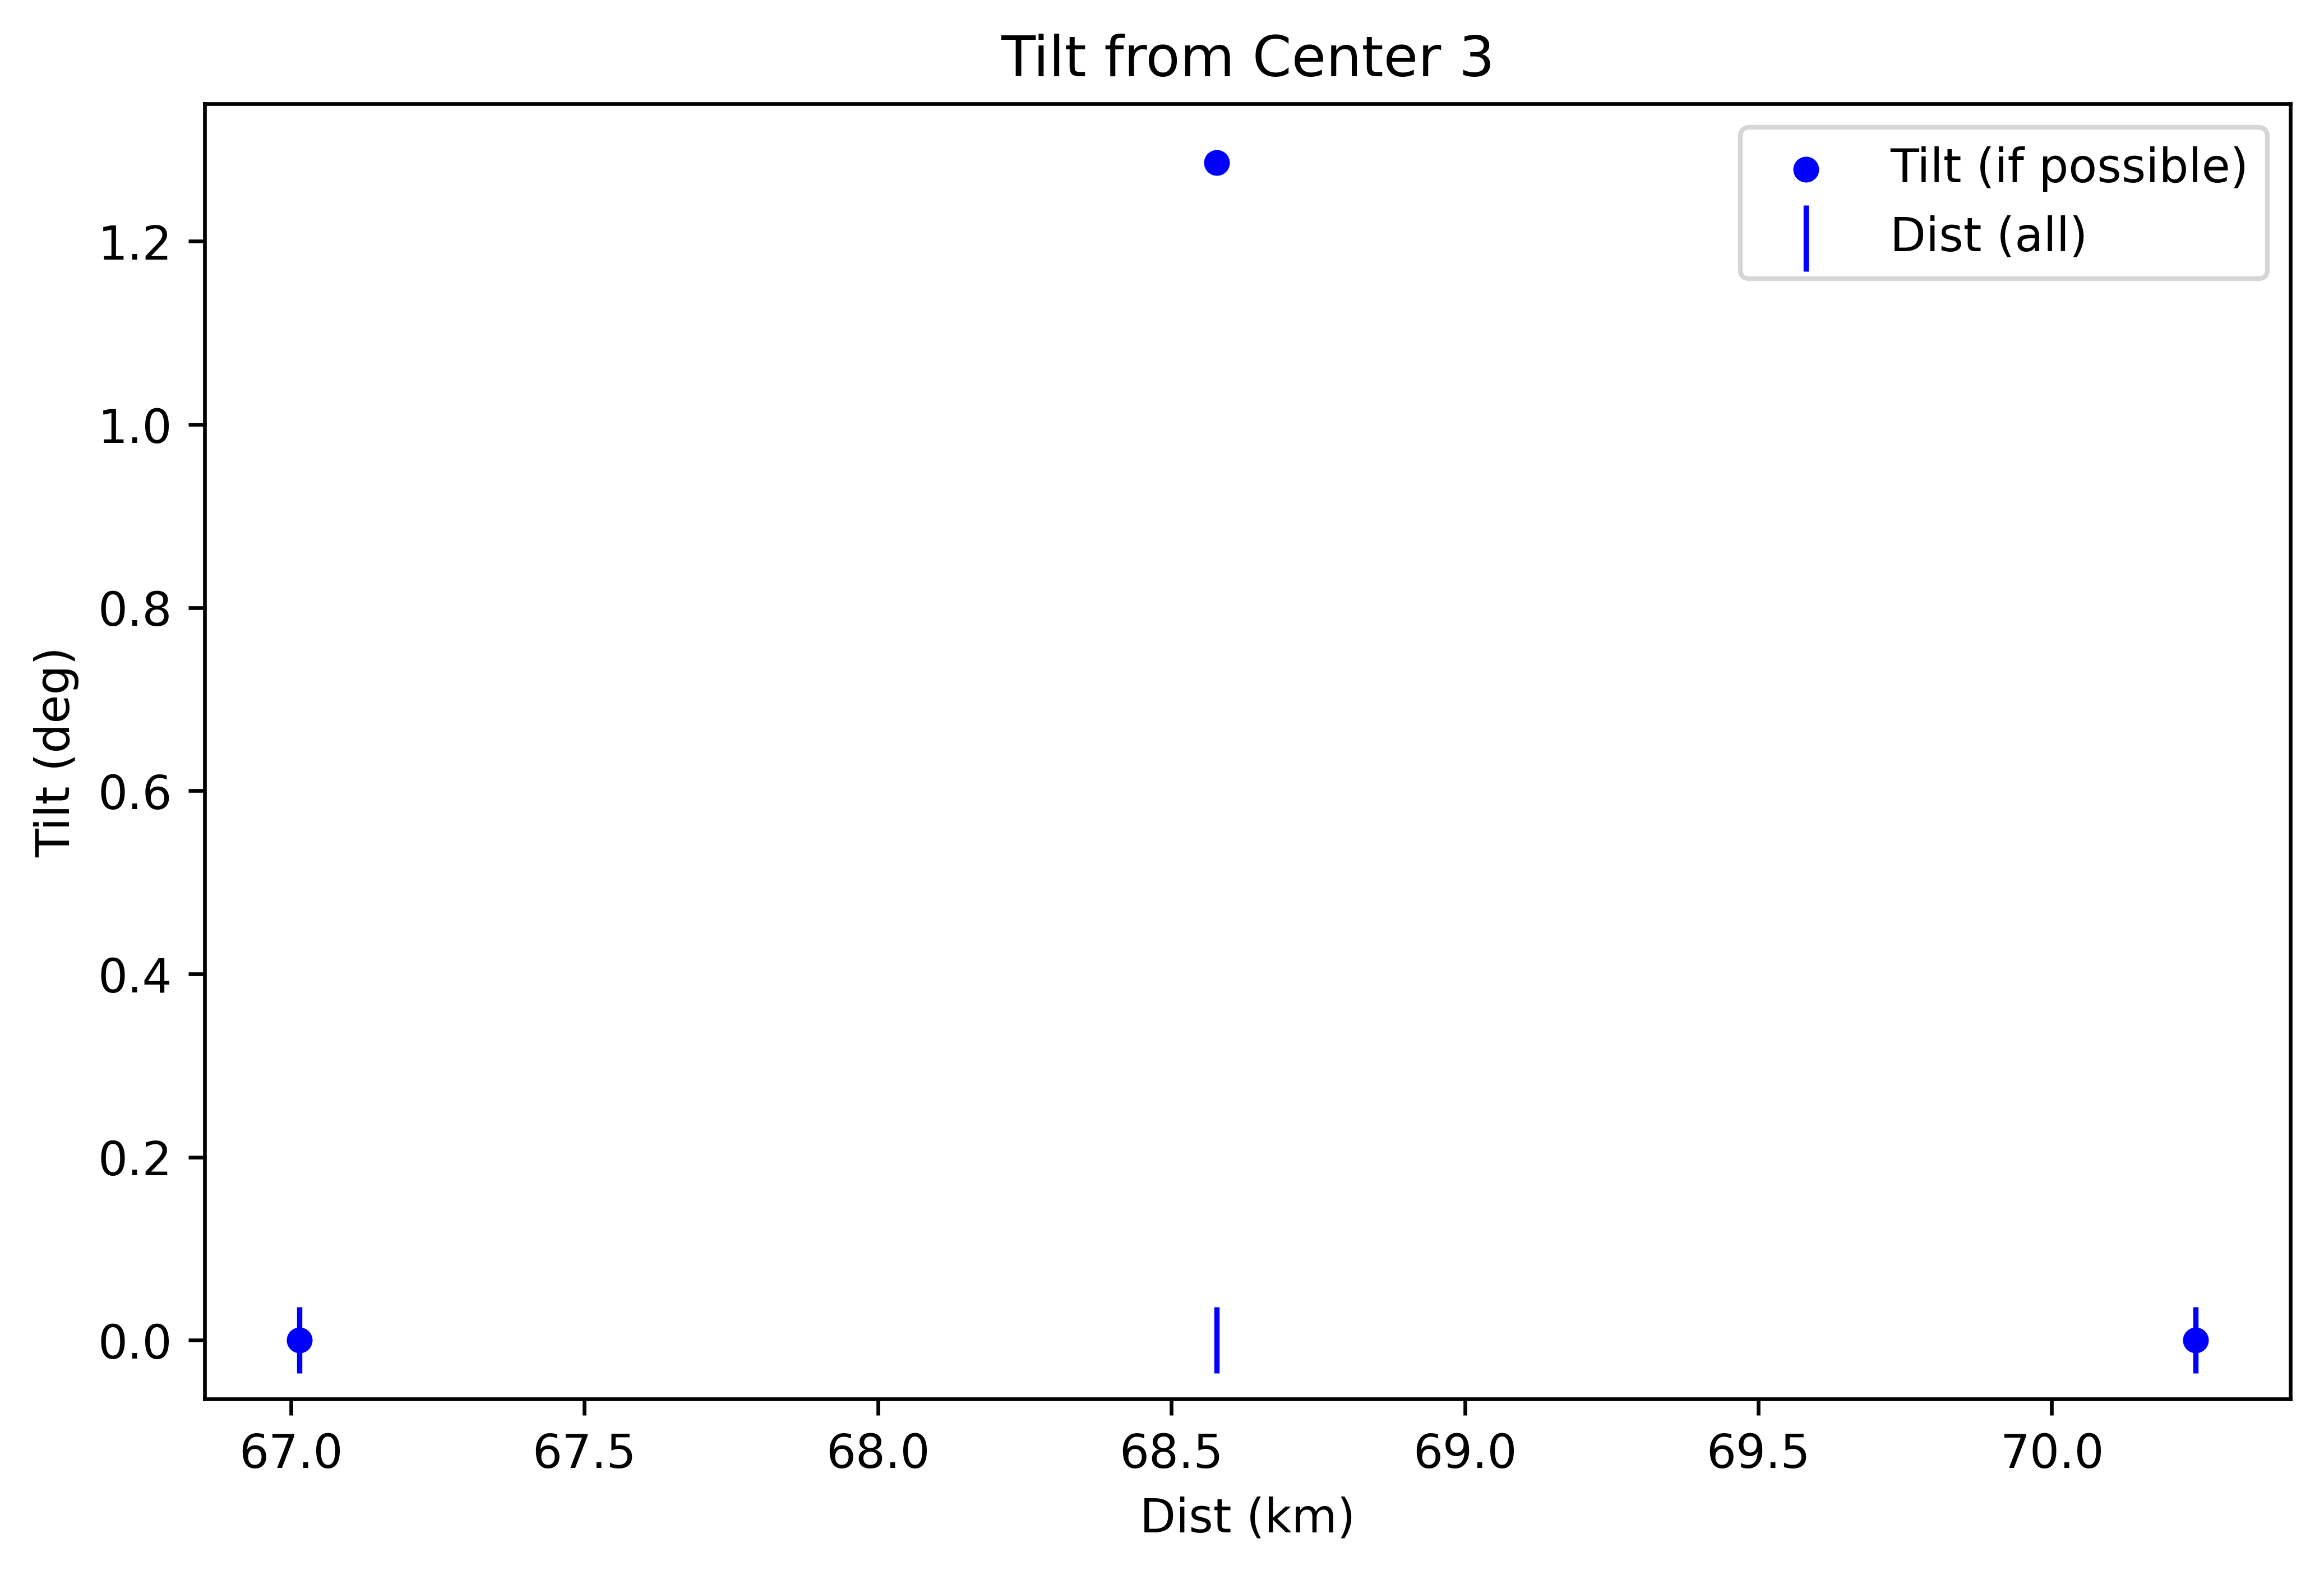

In [65]:
fig = plt.figure(figsize=(8, 5), dpi=600)

def plot_tilt_from_center(
        cID: int,
        has_legend: bool,
        sIDs: list = sIDs,
        name: str = None):  # type: ignore

    center = Center(cID)

    data = center.get_data_subset(sIDs)

    sns.scatterplot(data=data, x='dist_km', y='tilt')

    plt.title(f"Tilt from Center {cID}")

    plot_tilt_distance_dataset(
        df=data,
        color='Blue',
        has_legend=has_legend
    )

    # save plot with name if passed as argument
    if name is not None:
        save_pdf(name)

plot_tilt_from_center(
    cID = 3,
    has_legend=True,
    sIDs = [10, 11, 12],
)

Make an object for each center. This takes less than a minute on my machine.

In [8]:
# centers_calc = [Center(cID) for cID in cIDs]
centers_calc_dict = {cID: Center(cID) for cID in cIDs[:10]}

NameError: name 'Center' is not defined

In [9]:
centers_calc_dict_from_import = {
    cID: topodisc.make_center(cID, centers, samples) for cID in cIDs
}

Define sample populations based on their sIDs and feature type.

Define functions for center evaluation. These return dicts with score names as keys. They need to ALWAYS return dicts with the same keys (NaN values evaluation fails).

In [37]:
def summit_score(df: pd.DataFrame) -> dict:
    try:
        score = {'summit_score': mean(np.abs(df['beta1']))}
    except:
        score = {'summit_score': np.nan}
    return score


def fit_mogi_function(df: pd.DataFrame, full_output: bool = False):

    # initial guess lower than envelope
    if np.mean(df['tilt']) < 0:
        p0 = -MAX_EPV / 1000, TEST_D
    else:
        p0 = MAX_EPV / 1000, TEST_D

    fit = curve_fit(
        f=mogi_tilt,
        xdata=df['dist'],
        ydata=df['tilt'],
        p0=p0,
        maxfev=MAX_ITERATIONS,
        method='lm',
        full_output=full_output
    )
    
    return fit


def inflation_score(df: pd.DataFrame) -> dict:

    # get size of population before taking tiltable subset
    pop_size = len(df)

    df_subset = df.loc[df['is_tiltable']]

    # initialize output
    scores = {
        'frac_tiltable': len(df_subset) / pop_size,  # doesn't depend on fit results
        'log10_epv': np.nan,
        'epv_is_positive': np.nan,
        'depth': np.nan,
        'rmse': np.nan,
    }

    # attempt regression
    try:
        params, _, infodict, _, _ = fit_mogi_function(
            df_subset,
            full_output = True
        )

        # unpack param estimate and root mean squared error
        epv, depth = params
        rmse = np.sqrt(mean_squared_error(
            y_pred = infodict['fvec'],
            y_true = df_subset['tilt']
        ))

        # rewrite scores in dict
        scores['log10_epv'] = np.log10(np.abs(epv))
        scores['epv_is_positive'] = epv > 0 # boolean
        scores['depth'] = depth
        scores['rmse'] = rmse # type: ignore

    # catch regression failure
    except OptimizeWarning:  # does not converge
        pass

    except RuntimeError:
        pass

    except ValueError:
        pass

    except TypeError:  # 'func input vector length N=2 must not exceed func output vector length M=1'
        pass

    return scores

In [38]:
@dataclass
class Population:
    name: str
    sIDs: list

# not used
SE_ALL_sIDs = [
    41, 193, 194, 195, 196, 197, 198, 202, 203, 430, 431, 432, 438, 439, 440, 441, 442, 443, 444, 445, 477, 478, 479, 480, 481, 490,
    491, 492, 493, 524, 525, 526, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549
]

POP_A_sIDs = [
    198, 438, 439, 440, 441, 442, 443, 444, 445, 490, 491, 492, 493
]

POP_B_sIDs = [
    193, 194, 195, 196, 197, 477, 478, 479, 480, 481, 544, 545, 548, 549
]

POP_C_sIDs = [
    529, 530, 531, 532, 533, 537, 538, 539, 540, 541, 542, 543
]

pop_all = Population(name='all', sIDs=sIDs)
pop_flow = Population(name='flow', sIDs=feature_sIDs['flow'])
pop_channel = Population(name='channel', sIDs=feature_sIDs['channel'])

pop_a = Population(name='A', sIDs=POP_A_sIDs)
pop_b = Population(name='B', sIDs=POP_B_sIDs)
pop_c = Population(name='C', sIDs=POP_C_sIDs)

A criterion is a combination of an evaluation function and a population on which to use it. The evaluate_center function evaluates a single center using a single criterion.

In [39]:
@dataclass
class Criterion:
    func: Callable
    pop: Population

criteria = [
    Criterion(summit_score, pop_all),
    Criterion(summit_score, pop_flow),
    Criterion(summit_score, pop_channel),
    Criterion(inflation_score, pop_a),
    Criterion(inflation_score, pop_b),
    Criterion(inflation_score, pop_c),
]

def evaluate_center(center: Center, crit: Criterion):
    pop_subset = center.data.loc[crit.pop.sIDs]
    return crit.func(pop_subset)

Perform each evaluation for each center point. This takes less than two minutes on my machine, the vast majority of which is from the curve_fit function calls.

In [48]:
scores = {}
score_names = []

# note: will get score name out of order if any criteria throw errors, so those need to be handled in each evaluation function
for cID in cIDs:

    center = centers_calc_dict[cID]
    centers_eval = []

    for crit in criteria:
        center_crit_scores = evaluate_center(center, crit)

        for key, val in center_crit_scores.items():
            centers_eval.append(val)

            full_score_name = f'{crit.pop.name}_{key}'

            if full_score_name not in score_names:
                score_names.append(full_score_name)
                
    scores[cID] = centers_eval

/Users/henry/opt/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
/Users/henry/opt/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
/Users/henry/opt/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
/Users/henry/opt/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
/Users/henry/opt/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:900: RuntimeWarning: invalid value encountered in multiply
  pcov = pcov * s_sq
/Users/henry/opt/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
/Users/henry/opt/anacond

Write the evaluated scores to disk.

In [49]:
centers_eval = pd.DataFrame(scores).transpose().set_axis(score_names, axis=1)


centers_eval_no_infs = centers_eval.replace([np.inf, -np.inf], np.nan)

centers_eval_no_infs.to_csv(
    f'{map_path}centers_eval_first50.csv',
    index_label='cID'
)

Are computed parameters simply "hugging" those used to define the mogi tilt envelope? While they are centered around zero, they spread over multiple orders of magnitude, particularly the energy term which is much less constrained. Depth ranging over even a fraction of an oder of magnitude is convincing here (considering that the true range of realistic reservoir depths is a very narrow range).

In [50]:
def envelope_hugging(pops: list, name: str = None):  # type: ignore

    fig = plt.figure(figsize=(8, 4), dpi=600)
    ax_epv = fig.add_subplot(1, 2, 1)
    ax_d = fig.add_subplot(1, 2, 2)

    ax_d.yaxis.set_label_position("right")
    ax_d.yaxis.tick_right()

    fig.suptitle(
        f'Parameter Estimates "Hugging" Envelope with '
        + "$E_{PV} = $" + f'{MAX_EPV} J, '
        + f'$d = ${TEST_D/1000} km'
    )

    for pop in pops:

        d_est = centers_eval[f'{pop.name}_depth'][
            centers_eval[f'{pop.name}_depth'].notna()
        ]
        epv_est = centers_eval[f'{pop.name}_epv'][
            centers_eval[f'{pop.name}_epv'].notna()
        ]

        n_d = len(d_est)
        n_epv = len(epv_est)

        sns.kdeplot(x=np.log10(np.abs(epv_est / MAX_EPV)),
                    ax=ax_epv, label=f'{pop.name} (n = {n_epv})')

        sns.kdeplot(x=d_est / TEST_D, ax=ax_d, label=f'{pop.name} (n = {n_d})',bw_adjust=3)

    plt.sca(ax_d)
    plt.ylim((None, None))
    ax_d.vlines(x=1, ymin=0, ymax=1, colors=['black'])
    plt.xlabel('$d:$ fit / envelope')
    plt.legend()

    plt.sca(ax_epv)
    plt.ylim((None, None))
    ax_epv.vlines(x=0, ymin=0, ymax=1, colors=['black'])
    plt.xlabel('$E_{PV}:$ log |fit / envelope|')
    plt.legend()

    if name is not None:
        save_pdf(name)

#envelope_hugging([pop_a], ) # name='hugging-a'
#envelope_hugging([pop_b], ) # name='hugging-a'
#envelope_hugging([pop_c], ) # name='hugging-c'

Examine scatter plots and mogi fit functions for individual center candidates relative to a population.

In [70]:
def plot_scatter_fit(
        cIDs: list,
        pops: list,
        name: str = None,
        show_max: bool = False,
        show_min: bool = False,
        height: int = 3):  # type: ignore

    palette = itertools.cycle(sns.color_palette())  # type: ignore

    for cID in cIDs:
        for pop in pops:

            next_color = next(palette)

            spot_check = centers_calc_dict[cID].get_data_subset(pop.sIDs)
            plot_tilt_distance_dataset(spot_check, next_color)
            # sns.scatterplot(data=spot_check, x='dist_km', y='tilt')
            eval = centers_eval.loc[cID]

            log_epv = eval[f'{pop.name}_log10_epv']
            if eval[f'{pop.name}_epv_is_positive']:
                epv = 10**log_epv
            else:
                epv = -1 * 10**log_epv

            depth = eval[f'{pop.name}_depth']
            rmse = eval[f'{pop.name}_rmse']
            n = len(pop.sIDs)

            frac = eval[f'{pop.name}_frac_tiltable']

            if not np.isnan(epv):
                mogi_dist = np.linspace(
                    0,
                    np.max(spot_check['dist'][spot_check['tilt'].notna()]),
                    100
                )
                mogi_dist_km = mogi_dist / 1000
                label = f"Pop. {pop.name}. " + \
                    f"($f$ = {int(frac * n)}/{n}, RMSE = {round(rmse, 2)})"
                sns.lineplot(x=mogi_dist_km, y=mogi_tilt(
                    mogi_dist,
                    epv,
                    depth), label=label)

    # set extent based on data first, then add envelope
    plt.xlim(0, None)
    plt.ylim(-4, 4)

    plot_envelope(max=show_max, min=show_min)

    plt.ylabel('Tilt (deg)')
    plt.xlabel('Distance (km)')
    if len(cIDs) == 1:
        plt.title(f'Center {cIDs[0]}')
    # plt.title(f'Center Candidates for Pop. {pop.name}')
    # plt.legend(loc='upper left')

    # save plot with name if passed as argument
    if name is not None:
        save_pdf(name)

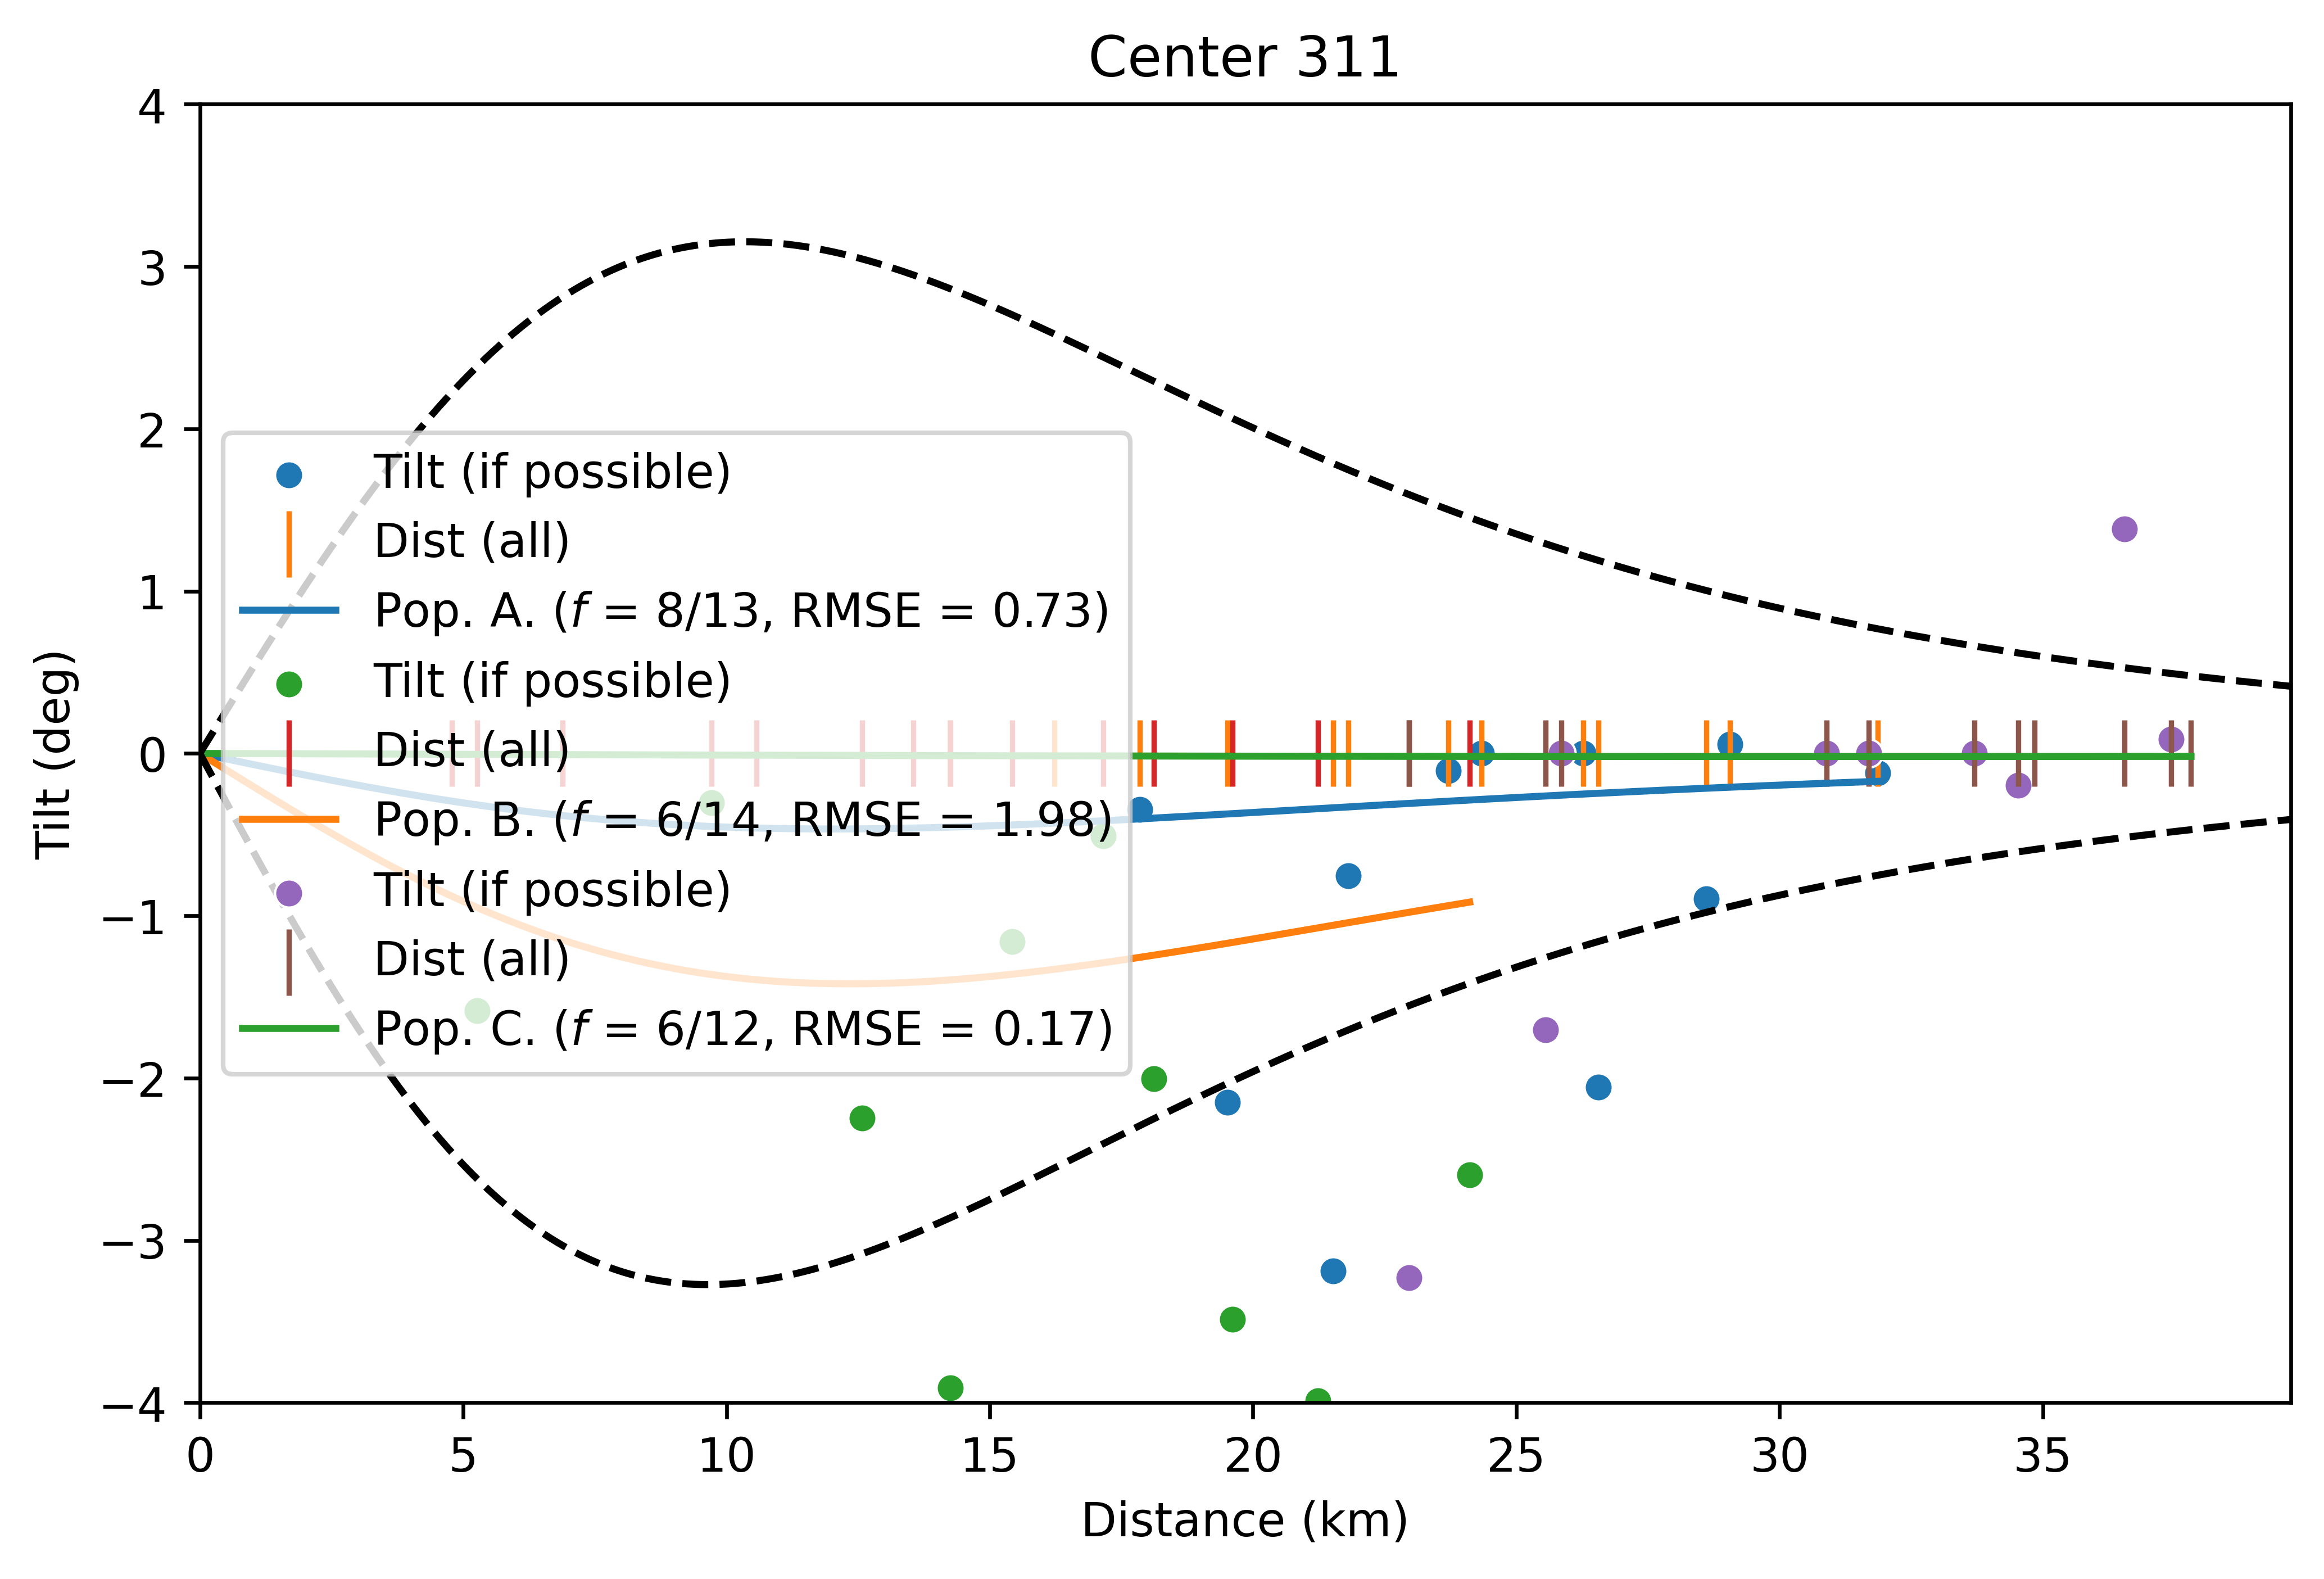

In [71]:
plt.figure(figsize=(8, 5), dpi=600)

plot_scatter_fit(
    [311],
    [pop_a, pop_b, pop_c],
    show_min=True,
    show_max=True,
    height=5,
    # name='results/scatter-fit-311'
)

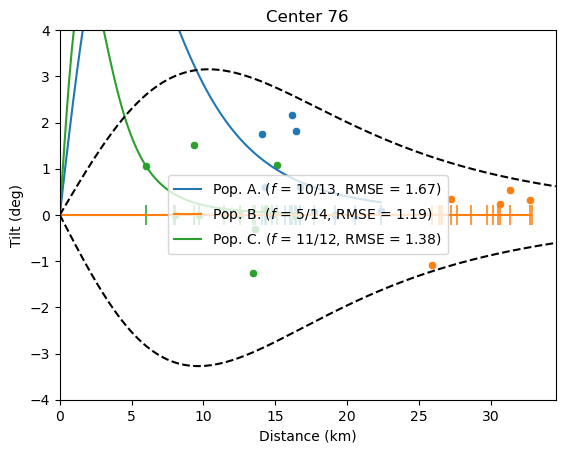

In [172]:
plot_scatter_fit(
    cIDs= [76],
    pops = [pop_a, pop_b, pop_c],
    show_min=True,
    show_max=True,
    height=5,
    # name='results/scatter-fit-76'
)

## Numerical Model Data

Read initial positions and displacement vectors (radial and vertical components) of mesh nodes.

In [4]:
model_path = "../GEOL192-Model/data/"

# paleo-edifice spline data
topo = np.genfromtxt(f'{model_path}z1.csv', delimiter=",").T


def model_pos1_from_csv(name: str):
    r = np.genfromtxt(model_path + "rdisp_" + name, delimiter=",")[:, 0]
    z = np.interp(r, *topo, right=0) # interpolate z1 into topography
    return np.array([r, z]).T


def model_disp_from_csv(name: str):
    r = np.genfromtxt(f'{model_path}rdisp_{name}', delimiter=",")[:, 1]
    z = np.genfromtxt(f'{model_path}zdisp_{name}', delimiter=",")[:, 1]
    return np.array([r, z]).T

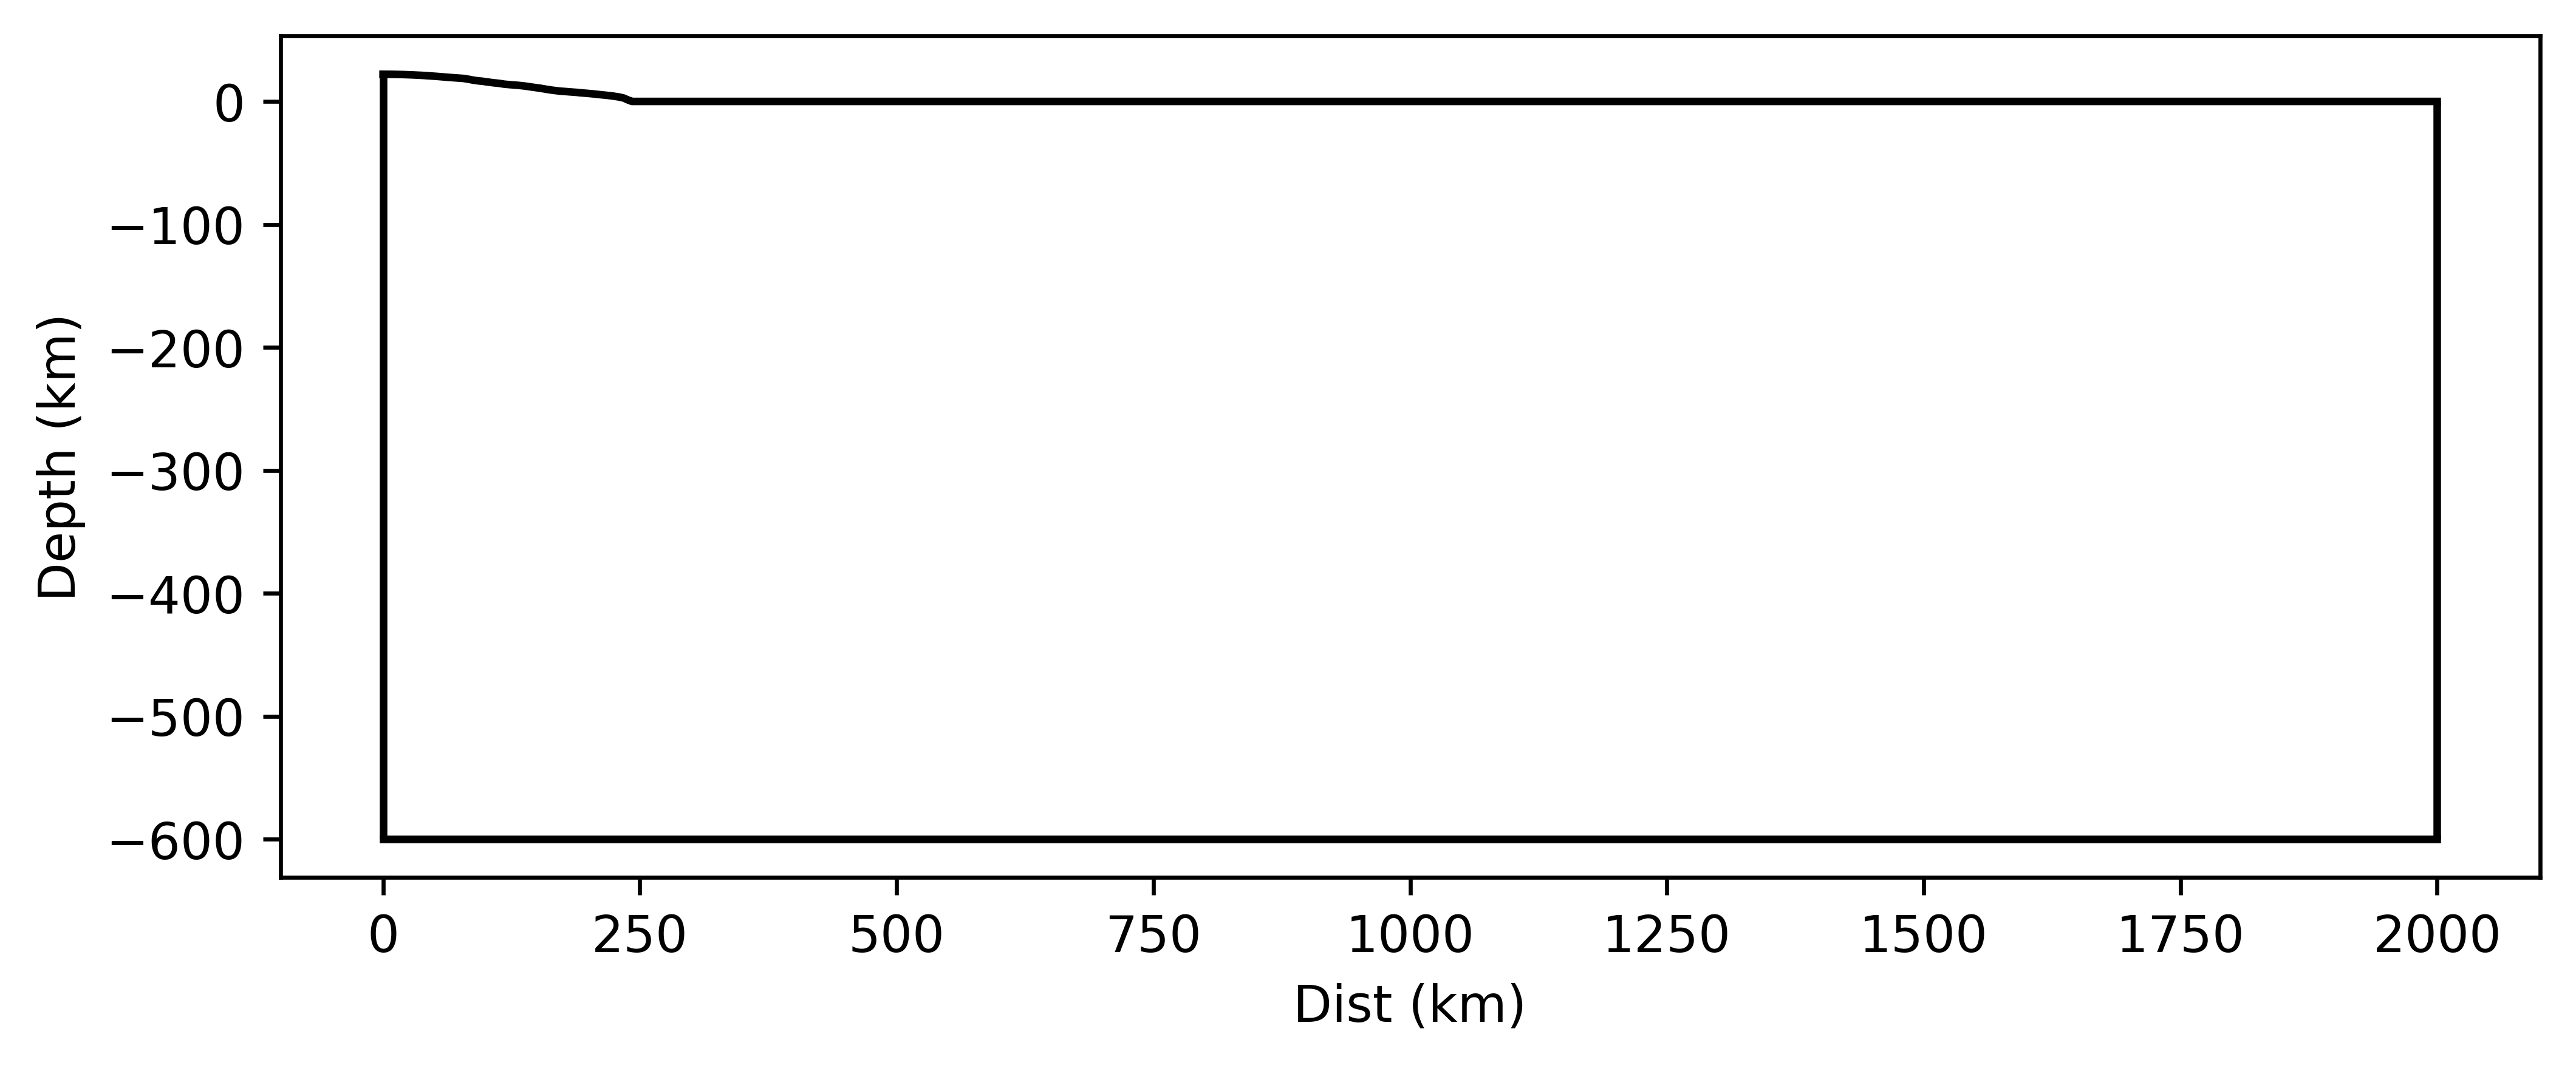

In [5]:
fig = plt.figure(figsize=(8,3), dpi=600)
plt.ylabel("Depth (km)")
plt.xlabel("Dist (km)")

def add_model_to_plot_km():
    # build section outline
    top_surface_km = np.concatenate((topo, [[2_000_000], [0]]),1) / 1000
    sns.lineplot(x=top_surface_km[0], y=top_surface_km[1], c='black')
    sns.lineplot(x=[0, 2000], y=[-600, -600], c='black')
    plt.vlines(x=[0,2_000], ymin=-600, ymax=[top_surface_km[1,0], 0], colors=['black'])

add_model_to_plot_km()

Define objects for displaced nodes and surface edges (the latter defined by a consecutive pair of the former). Tilt calculation in the edge class.

In [6]:
@dataclass
class Node:
    pos1: Tuple[float, float]
    disp: Tuple[float, float]

    def __post_init__(self):
        self.pos2 = self.pos1 + self.disp


@dataclass
class Edge:
    proximal: Node  # (A in text)
    distal: Node  # (B in text)

    def __post_init__(self):
        # relative dimensions [r, z] of initial and displaced segments
        self.shape1 = self.distal.pos1 - self.proximal.pos1  # type: ignore
        self.shape2 = self.distal.pos2 - self.proximal.pos2  # type: ignore

        # mean position of initial and displaced segments
        self.pos1 = (self.distal.pos1 + self.proximal.pos1) / 2  # type: ignore
        self.pos2 = (self.distal.pos2 + self.proximal.pos2) / 2  # type: ignore

        # radial distances for plotting
        self.dist = self.pos2[0]
        self.dist_km = self.dist / 1000

        # initial and displaced slopes (positive downward from center)
        # index [1] is z component; [0] is r component
        self.slope1 = deg(arctan2(-self.shape1[1], self.shape1[0]))
        self.slope2 = deg(arctan2(-self.shape2[1], self.shape2[0]))

        self.tilt = self.slope2 - self.slope1

Define model class with parameter combination (geometry, overpressure). It reads .csv files, builds nodes & edges, etc.

In [7]:
@dataclass
class Model:
    params: dict

    def __post_init__(self):

        self.radius = self.params['radius']
        self.half_height = self.radius * self.params['aspect']

        self.dP = self.params['pmult'] * \
            self.params['depth'] * ROCK_DENSITY * MARS_GRAVITY

        self.res_vol = (4 / 3) * np.pi * self.radius**2 * self.half_height

        self.epv = self.dP * self.res_vol
        self.d = self.params['depth'] + self.half_height

        filename = f"depth_{self.params['depth']}_radius_{self.params['radius']}_aspect_{self.params['aspect']}_pmult_{self.params['pmult']}_grav_{int(self.params['grav'])}_topo_{int(self.params['topo'])}.csv"

        # read initial positions and displacements
        self.pos1 = model_pos1_from_csv(filename)
        self.disp = model_disp_from_csv(filename)

        # subtract out gravitational component (with no overpressure)
        if self.params['grav']:
            filename_p0 = filename.replace(
                f"pmult_{self.params['pmult']}", "pmult_0")
            self.disp -= model_disp_from_csv(filename_p0)

        # make z1 flat for flat model
        if not self.params['topo']:
            self.pos1[1] = np.zeros(len(self.pos1[1]))

        # build nodes from pos1 and disp if pos1 within defined length
        self.num_nodes = next(i for i, val in enumerate(self.pos1)
                              if val[0] > PLOT_WIDTH)

        self.nodes = [Node(self.pos1[i], self.disp[i])
                      for i in range(self.num_nodes)]

        # build edges from consecutive node pairs
        self.node_pairs = zip(self.nodes[:-1], self.nodes[1:])
        self.edges = [Edge(*pair) for pair in self.node_pairs]

        # put edge attributes into dict of lists
        self.data = pd.DataFrame(
            [vars(edge) for edge in self.edges])

        self.attributes = self.data.to_dict("list")

Define parametric sweep class to mirror COMSOL iterative modelling. The main purpose of this object is two plots: one which distinguishes between constant and variable parameters within the sweep and can handle comparisons with the analytical Mogi solution, one to plot the axisymmetric cross-section.

In [8]:
geom_keys = ['depth', 'radius', 'aspect']

# parameter sweep in SI units (to match csv output from COMSOL)
@dataclass
class ParamSweep:
    params: dict

    def __post_init__(self):


        # define constant parameters for labelling once in title
        self.constants = {key: val[0]
                          for key, val in self.params.items() if len(val) == 1}
        

        # define variable parameters for labelling individually
        self.variables = [key for key, val in self.params.items() if len(val) > 1]

        # subset of params
        self.geom_params = {k:self.params[k] for k in geom_keys if k in self.params}

                # define constant parameters for labelling once in title
        self.geom_constants = {key: val[0]
                          for key, val in self.geom_params.items() if len(val) == 1}

        # define variable parameters for labelling individually
        self.geom_variables = [key for key, val in self.geom_params.items() if len(val) > 1]

        self.models = [Model(dict(zip(self.params, item)))
                       for item in itertools.product(*self.params.values())]

    def plot_tilt(self, calc_mogi: bool = False, fit_mogi: bool = False, name: str = None):  # type: ignore

        fig = plt.figure(figsize=(8, 3), dpi=600)

        title = f'{self.constants}'.replace(
            "{", "").replace("}", "").replace("'", "")
        
        for model in self.models:

            model_epv = epv_numerical_model(
                model.params['depth'],
                model.params['radius'],
                model.params['aspect'],
                model.params['pmult']
            )

            # define variables specific to each config
            if len(self.variables) > 0:
                label = ': {}'.format(
                    {param: model.params[param] for param in self.variables})
                label = label.replace("{", "")
                label = label.replace("}", "")
                label = label.replace("'", "")
            else:
                label = ""

            # plot numerical output
            sns.lineplot(data=model.attributes,
                             y="tilt", x="dist_km", label=f'Numerical{label}')

            if calc_mogi:
                dist = np.array(model.attributes['dist'])
                dist_km = dist / 1000
                tilt = mogi_tilt(
                    dist=dist,
                    epv=model_epv,
                    d=model.params['depth']
                )
                sns.lineplot(x=dist_km, y=tilt, label=f'Mogi (calc){label}')

            if fit_mogi:
                params, _ = fit_mogi_function(df=model.data)
                epv, d = params

                sns.lineplot(x=model.data['dist_km'], y=mogi_tilt(
                    model.data['dist'], epv, d), label=f'Mogi (fit){label}')
                
                epv_overestimate = epv / model_epv
                d_overestimate = d / model.params['depth']

                title += '\n Fitted parameter overestimation Factors: '
                title += '$E_{PV}:$' + f'{round(epv_overestimate,2)}, '
                title += '$d:$' + f'{round(d_overestimate, 2)}'


        plt.title(f"{title}")
        plt.xlabel("Distance (km)")
        # plt.xlim(8, 16) 
        # plt.ylim(.34, .37)
        plt.ylabel("Tilt (deg)")
        plt.legend(loc="upper right")

        # save plot with name if passed as argument
        if name is not None:
            save_pdf(name)
    
    def plot_section(self): # type: ignore
        
        fig, ax = plt.subplots(figsize=(8,3),dpi=600)

        add_model_to_plot_km()

        title_dict = self.geom_constants.copy()

        if 'depth' in title_dict.keys():
            title_dict['depth'] = f"{title_dict['depth'] / 1000} km"

        if 'radius' in title_dict.keys():
            title_dict['radius'] = f"{title_dict['radius'] / 1000} km"

        title = f'{title_dict}'.replace(
            "{", "").replace("}", "").replace("'", "")

        depth = self.params['depth']
        radius = self.params['radius']
        aspect = self.params['aspect']

        for model in self.models:
            # define variables specific to each config
            if len(self.geom_variables) > 0:

                label_dict = model.params.copy()

                if 'depth' in label_dict.keys():
                    label_dict['depth'] = f"{label_dict['depth'] / 1000} km"

                if 'radius' in label_dict.keys():
                    label_dict['radius'] = f"{label_dict['radius'] / 1000} km"

                label = '{}'.format(
                    {param: label_dict[param] for param in self.geom_variables})
                label = label.replace("{", "")
                label = label.replace("}", "")
                label = label.replace("'", "")
            else:
                label = ""

            depth = model.params['depth']
            aspect = model.params['aspect']
            radius = model.params['radius']

            v= -depth/1000    #y-position of the center
            a= radius / 1000     #radius on the x-axis
            b= radius*aspect / 1000    #radius on the y-axis
            t = np.linspace(-np.pi/2, np.pi/2, 100)
            plt.plot(a*np.cos(t), v+b*np.sin(t), label=label)

Define specific parametric sweeps.

(-40.0, 30.0)

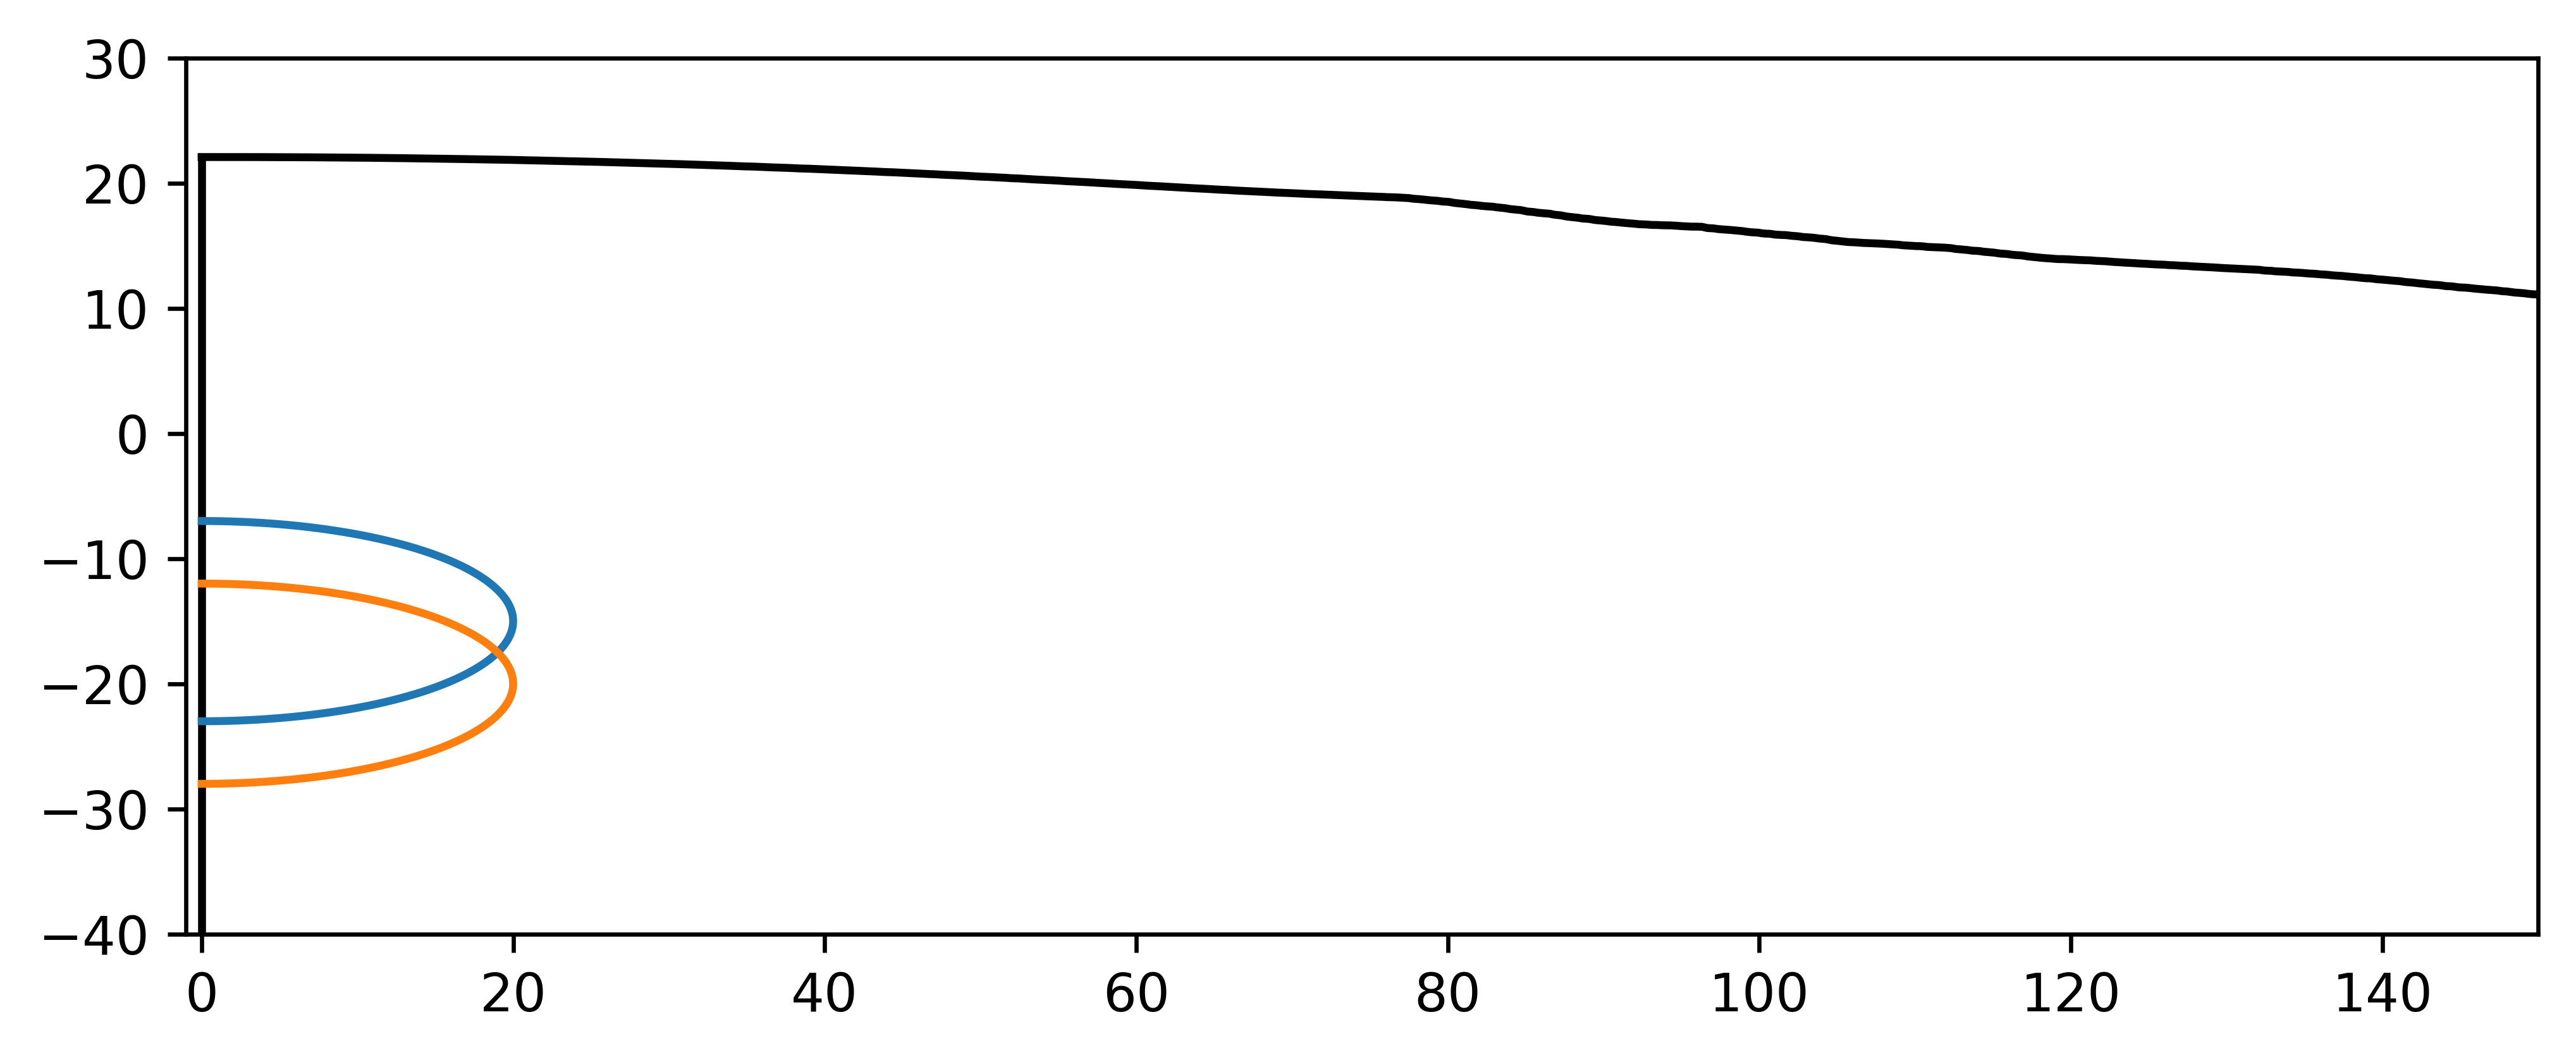

In [9]:
grav_topo_test_sweep = ParamSweep({
    "depth": [15_000],
    "radius": [20_000],
    "aspect": [.4],
    "pmult": [.6],
    "grav": [True, False],
    "topo": [True, False],
})

mogi_shallow_oblate_test_sweep = ParamSweep({
    "depth": [15_000, 20000],
    "radius": [20_000],
    "aspect": [.4],
    "pmult": [.6],
    "grav": [False],
    "topo": [True],
})

mogi_test_sweep = ParamSweep({
    "depth": [25_000],
    "radius": [5_000],
    "aspect": [1],
    "pmult": [1],
    "grav": [False],
    "topo": [False],
})

full_sweep = ParamSweep({
    "depth": [25_000], # 25
    "radius": [5_000], # 5
    "aspect": [1],
    "pmult": [1],
    "grav": [False],
    "topo": [False],
})

mogi_shallow_oblate_test_sweep.plot_section() # name='methods/model-section'

plt.xlim(-1, 150)
plt.ylim(-40, 30)

# save_pdf(name='methods/model-section-zoom')

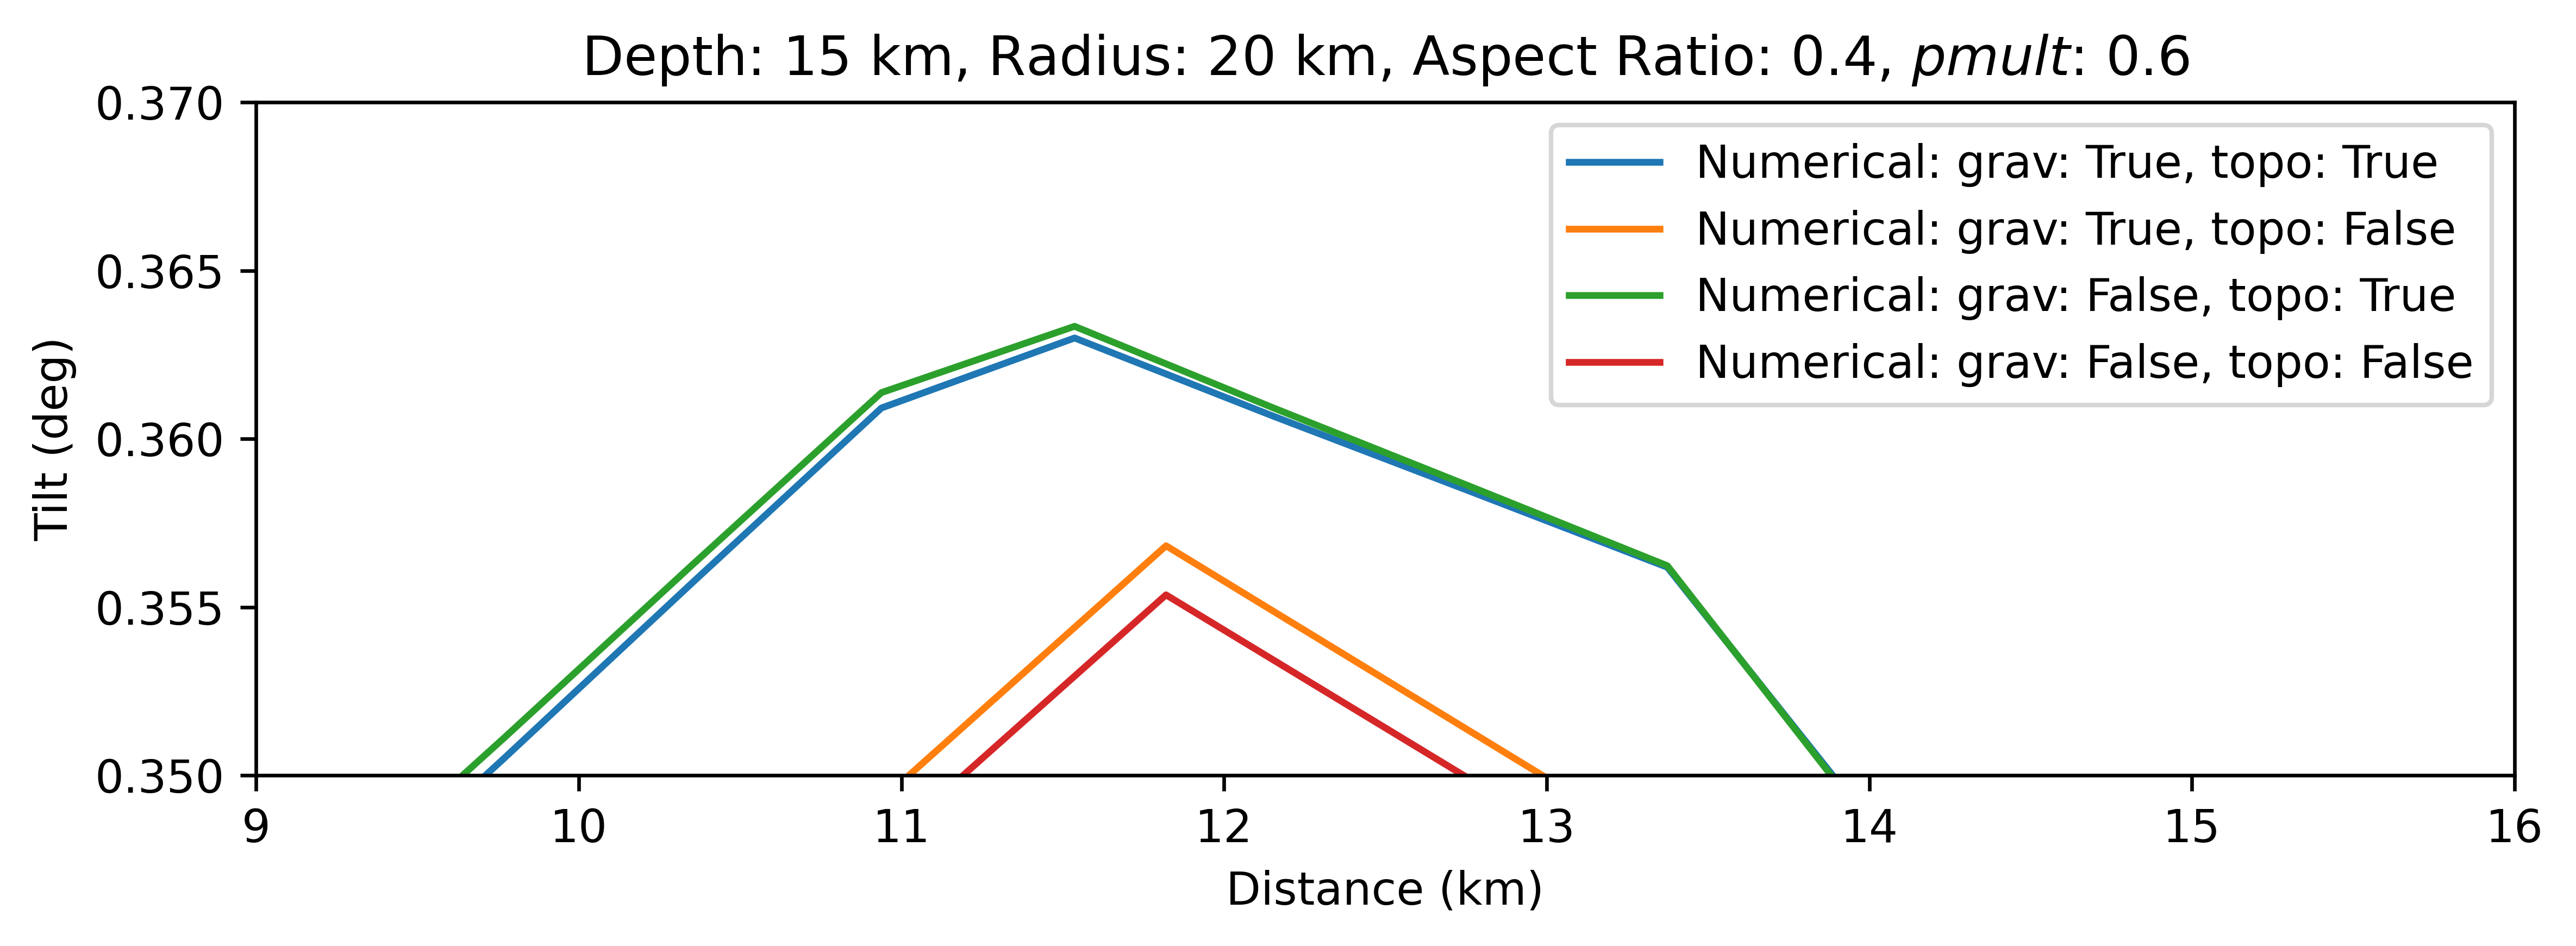

In [17]:
grav_topo_test_sweep.plot_tilt(
    # name='grav-topo-test'
)  

# mogi_test_sweep.plot_tilt(
#     calc_mogi=True,
#     fit_mogi=True,
#     # name='mogi-test'
# )  


# mogi_shallow_oblate_test_sweep.plot_tilt(
#     calc_mogi=True,
#     fit_mogi=True,
#     # name='mogi-test-shallow-oblate'
# )

plt.title('Depth: 15 km, Radius: 20 km, Aspect Ratio: 0.4, $pmult$: 0.6')

plt.xlim(9,16)
plt.ylim(.35,.37)

# save_pdf('methods/grav-topo-test')
save_pdf('methods/grav-topo-test-zoom')


<Figure size 4800x2400 with 0 Axes>

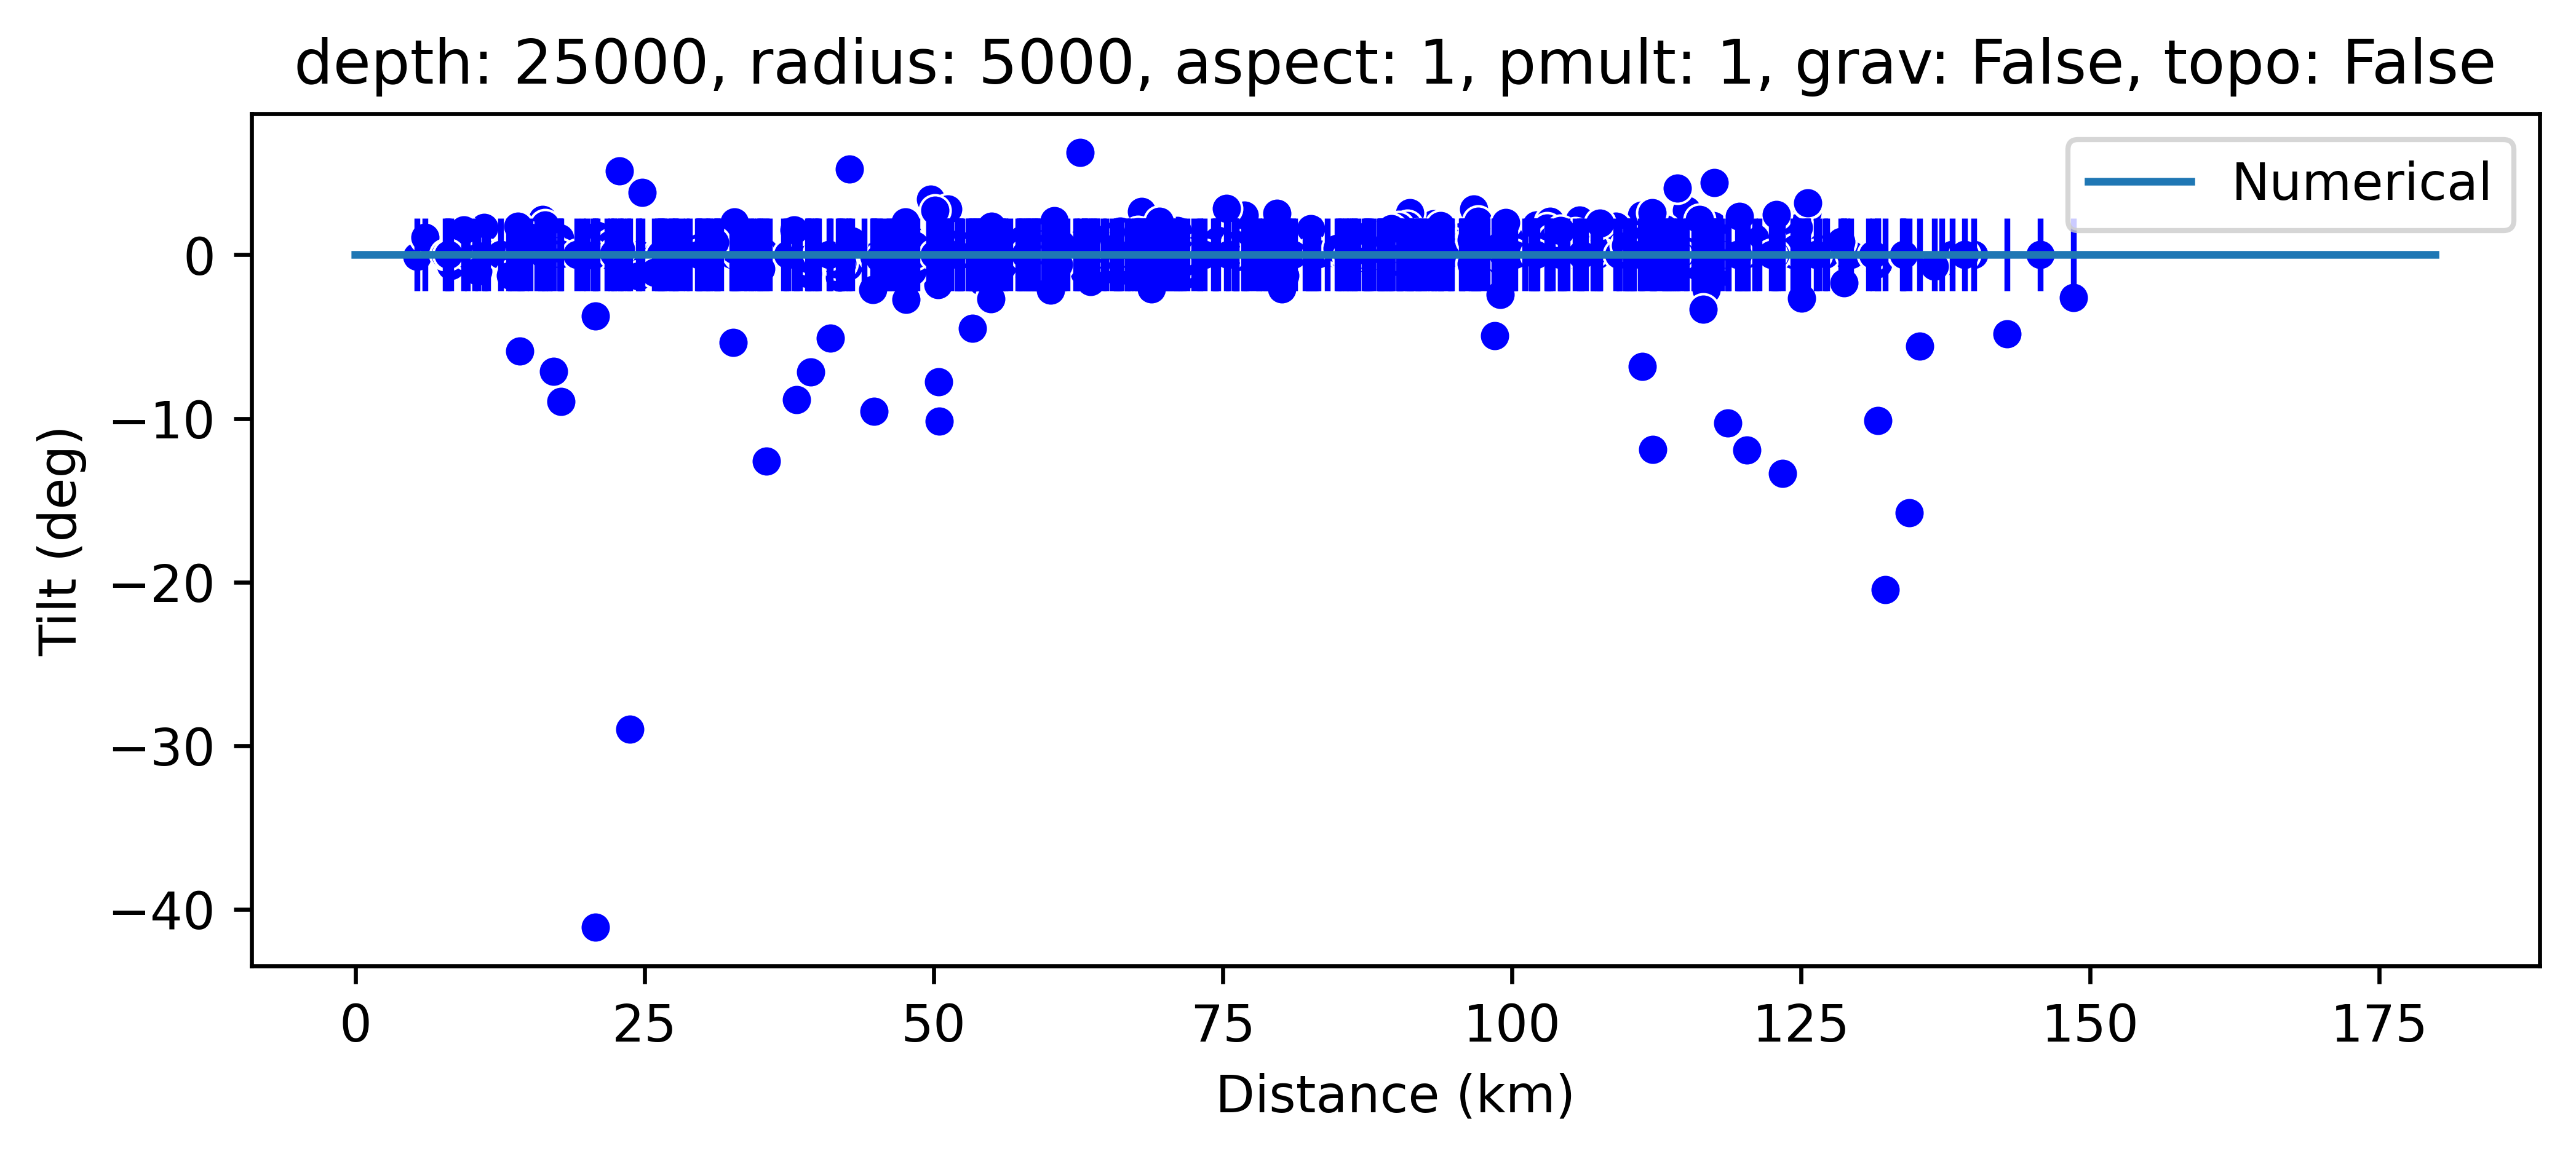

In [175]:
plt.figure(figsize=(8,4), dpi=600)

full_sweep.plot_tilt(
    
)

plot_tilt_distance_dataset(
    df=centers_calc[75].data,
    color='blue'
)

Define a function for plotting a full center scatter plot against a numerical sweep. (Not used in manuscript).

In [ ]:
def numerical_fit_plot(sweep: ParamSweep, center: Center, pops: list, name: str = None): # type: ignore
    fig = plt.figure(figsize=(8, 5), dpi=600)

    for model in sweep.models:
        label = '{}'.format({param: model.params[param] for param in sweep.variables})
        label = label.replace("{", "")
        label = label.replace("}", "")
        label = label.replace("'", "")
        sns.lineplot(data=model.attributes, y="tilt", x="dist_km", label=label)


    sns.scatterplot(data=center.data, x='dist_km', y='tilt', label=center.cID)

    model_title = f'{sweep.constants}'
    model_title = model_title.replace("{", "")
    model_title = model_title.replace("}", "")
    model_title = model_title.replace("'", "")
    plt.title(f"Radial Tilt: {model_title}")

    plt.title(f"Model Parameters: {model_title}")
    plt.xlabel("Distance (km)")
    plt.ylabel("Tilt (deg)")
    plt.legend()

    # save plot with name if passed as argument
    if name is not None:
        save_pdf(name)

numerical_fit_plot(mogi_shallow_oblate_test_sweep, [centers_calc[0]])

In [3]:
@dataclass
class TestModel:
    array: np.array

In [4]:
test_model_1 = TestModel(np.array([0,1,2]))

In [5]:
test_model_1

TestModel(array=array([0, 1, 2]))